# <h1 style="color:red;"><b>John's Swing-Trading Code (Python Translation)<b></h1>

### <h3 style="color:yellow;">Importing Modules and Packages</h3>

In [1]:
from datetime import datetime, date, timedelta
import time
import pandas_market_calendars as mcal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import random
import os
from google.cloud import bigquery
from google.oauth2 import service_account
import sys
from tqdm import tqdm  # optional: for a progress bar
import warnings
import schwabdev
from dotenv import load_dotenv
warnings.filterwarnings("ignore")  # silence any pandas SettingWithCopy warnings
import requests
from io import StringIO
import random
import shutil

## <h2 style="color:purple;">Authentication</h2>

### <h3 style="color:yellow;">Authentication for Schwab</h3>

Load environment variables from .env file for authentification purposes

In [2]:
load_dotenv()

True

Set the display options

In [3]:
# Display options
# Set the global float format to 4 decimal places
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
pd.options.display.float_format = '{:,.4f}'.format # Format numerical output to have certain number of decimals
# pd.options.display.float_format = None # Reset to default numerical output formatting
pd.set_option('display.width', 2000) # Set the display width to a large number
pd.set_option('display.max_colwidth', 1000) # Set max column width to a large number

pd.set_option('display.max_columns', None) # Displays all columns
# pd.set_option('display.max_rows', None) # Displays all rows                             
# pd.reset_option('display.max_columns') # Display default abbreviated columns
pd.reset_option('display.max_rows') # Display default abbreviated rows

Create the client object.

In [4]:
app_key = os.getenv('app_key')
app_secret = os.getenv('app_secret')
callback_url = os.getenv('callback_url')

# Print them to verify (avoid printing sensitive info in production)
print(f"App Key: {app_key}")
print(f"App Secret: {app_secret}")
print(f"Callback URL: {callback_url}")

# Now proceed to initialize the client
client = schwabdev.Client(app_key, app_secret, callback_url)
print('Client initialized!')

App Key: 2C7Jh6zt5QdlSb0N5RnhWpaiEzKFr150
App Secret: OQGxH0GkD5bAEMA4
Callback URL: https://127.0.0.1
Client initialized!


Use this when in need of updating the refresh token.

In [5]:
# client.update_tokens(force=True)
# client = schwabdev.Client(app_key, app_secret, callback_url)

### <h3 style="color:yellow;">Authentication for GBQ</h3>

This block defines the config() function, which returns the full path to a Google Cloud service account key file based on the username provided. It supports two users (reese and ben) and raises an error if an unrecognized username is passed. The returned path is used later for authenticating BigQuery queries securely.

In [6]:
gbq_proj_id = 'stock-chipper-87578' 

def config(username=None):
    if username == 'reese':
        file_dir = "C:/Users/rsmcd/OneDrive/Desktop/Trade Review/stock-chipper-research/"
        credential_file = 'stock-chipper-87578-ec8b427fca6a.json'
    elif username == 'ben':
        file_dir = "C:/Users/benwo/Documents/repos/stock-chipper-app/creds/"
        credential_file = "stock-chipper-87578-b17ad3f7e6e1.json"
    else:
        raise ValueError(f"Unrecognized or missing username: {username}")
    
    return file_dir + credential_file

Determines which user's credentials to use based on the environment:

If the script is run via the command line (__name__ == "__main__"), it expects a username to be passed as an argument (e.g., python script.py reese).

If no username is provided or the script is running in a Jupyter notebook or other non-CLI context, it defaults to "reese".

If an error occurs during detection, it falls back to using "reese" as a safe default.

The result is stored in private_key and later used to authenticate BigQuery access.

In [7]:
# Use default when in Jupyter or if __main__ but no args
try:
    if __name__ == "__main__":
        if len(sys.argv) <= 1:
            raise ValueError("No username provided via CLI args")
        private_key = config(sys.argv[1])
    else:
        private_key = config("reese")  # Default for notebook
except Exception as e:
    print("Falling back to default username (reese)")
    private_key = config("reese")

Falling back to default username (reese)


## <h2 style="color:purple;">Defining Functions</h2>

In [8]:
def get_ticker_data(ticker, date_pull_begin=None, local=False, local_folder="local-ticker-data-schwab", credentials_path=None, project_id=None):
    """
    Retrieves historical daily OHLC data for a given ticker, either from a local file or from BigQuery.

    If `local` is True, the function reads the data from a local TSV file under the specified folder.
    Otherwise, it queries the `stocks_candle_1day` table in BigQuery.

    Args:
        ticker (str): The stock ticker symbol to retrieve data for.
        date_pull_begin (datetime-like, optional): The earliest date to pull data from.
            Defaults to two years before today if not provided.
        local (bool): Whether to read from a local file instead of querying BigQuery.
        local_folder (str): Name of the subfolder under 'data/' containing local files.
            Options include "local-ticker-data-gbq" or "local-ticker-data-schwab".
        credentials_path (str, optional): Full path to the GCP service account JSON key.
            Required if `local` is False.
        project_id (str, optional): GCP project ID. Required if `local` is False.

    Returns:
        pd.DataFrame: A DataFrame containing columns ['ticker', 'date_time', 'high', 'low'].

    Raises:
        ValueError: If `credentials_path` or `project_id` is missing when `local` is False.
    """
    if local:
        file_path = Path("strategies/swing-trading/data") / local_folder / f"{ticker}.csv"
        return pd.read_csv(file_path, sep="\t", parse_dates=["date_time"])

    if date_pull_begin is None:
        date_pull_begin = pd.Timestamp.today() - pd.DateOffset(years=2)

    sql = f"""
        SELECT ticker, date_time, high, low
        FROM `stock-chipper-87578.first_rate.stocks_candle_1day`
        WHERE date_time > '{date_pull_begin:%Y-%m-%d}' AND ticker = '{ticker}'
        ORDER BY date_time ASC
    """

    return run_sql_query(sql, project_id=project_id, credentials_path=credentials_path)

def get_trades(data, upper_bound, lower_bound, time_start):
    """
    Simulates a basic swing trading strategy using high/low breakouts.

    Iterates over a DataFrame of daily OHLC data to identify buy and sell trades:
    - A **buy** occurs when the low of the day falls below or equals the `lower_bound`.
    - A **sell** occurs when the high of the day rises above or equals the `upper_bound`.
    - Only one position can be held at a time.
    - If the end of the data is reached while a position is open, it is force-closed 
      at the midpoint of the final day's high and low.

    Args:
        data (pd.DataFrame): Daily OHLC data with columns ['date_time', 'high', 'low'].
        upper_bound (float): The price level that triggers a sell.
        lower_bound (float): The price level that triggers a buy.
        time_start (datetime-like): Trades are only evaluated for rows on or after this timestamp.

    Returns:
        pd.DataFrame: A DataFrame of executed trades with columns:
            ['date', 'type', 'daily_high', 'daily_low', 'trade_price']
    """
    time_start = pd.to_datetime(time_start)  # Ensure compatible type for comparison
    data = data.copy()
    data["date_time"] = pd.to_datetime(data["date_time"])    
    state = 0                                                                                     # 0 = not in position, 1 = in position
    trades = []                                                                                   # List to store executed trades

    for i, row in data.iterrows():                                                                # Iterate over each row in the data
        if row["date_time"] < time_start:                                                         # Skip rows before the time_start threshold
            continue                                                                              # Move to the next row

        if state == 0 and row["low"] <= lower_bound:                                              # Entry condition: not in position and price hits or drops below lower bound
            trades.append({                                                                       # Record a buy trade
                "date": row["date_time"],                                                         # Trade date
                "type": "buy",                                                                    # Trade type
                "daily_high": row["high"],                                                        # High of the day
                "daily_low": row["low"],                                                          # Low of the day
                "trade_price": lower_bound                                                        # Executed price at lower bound
            })
            state = 1                                                                             # Update state to indicate we are now in a position
        elif state == 1 and row["high"] >= upper_bound:                                           # Exit condition: in position and price rises above upper bound
            trades.append({                                                                       # Record a sell trade
                "date": row["date_time"],                                                         # Trade date
                "type": "sell",                                                                   # Trade type
                "daily_high": row["high"],                                                        # High of the day
                "daily_low": row["low"],                                                          # Low of the day
                "trade_price": upper_bound                                                        # Executed price at upper bound
            })
            state = 0                                                                             # Update state to indicate we're out of position

    if state == 1:                                                                                # If still in position at the end, force close
        last = data.iloc[-1]                                                                      # Get the last row in the data
        trades.append({                                                                           # Record a forced sell trade
            "date": last["date_time"],                                                            # Trade date
            "type": "sell",                                                                       # Trade type
            "daily_high": last["high"],                                                           # High of the day
            "daily_low": last["low"],                                                             # Low of the day
            "trade_price": 0.5 * (last["high"] + last["low"])                                     # Forced close price is midpoint between high and low
        })

    return pd.DataFrame(trades)                                                                   # Convert list of trades to a DataFrame and return

def get_returns(data, upper_bound, lower_bound, time_start, starting_cash=10000):
    """
    Simulates a swing trading strategy and calculates the annualized return.

    Executes trades based on breakout conditions using `get_trades()`:
    - Buys when price hits `lower_bound`
    - Sells when price hits `upper_bound`
    - Assumes full portfolio allocation on each trade (no partial positions)
    - Closes the final position at the end of the data if still open

    Computes:
    - The total number of buy-side trades
    - The annualized return over the trading period

    Args:
        data (pd.DataFrame): Daily OHLC data with columns ['date_time', 'high', 'low'].
        upper_bound (float): Price level that triggers a sell.
        lower_bound (float): Price level that triggers a buy.
        time_start (datetime-like): The start date for evaluating trades.
        starting_cash (float): Initial portfolio cash. Defaults to 10,000.

    Returns:
        dict: {
            "annualized_return" (float or None): Annualized percentage return,
                or None if no trades were executed or time span is 0.
            "num_trades" (int): Number of completed buy trades.
        }
    """
    trades = get_trades(data, upper_bound, lower_bound, time_start)                             # Run the trade simulation using breakout rules

    if trades.empty:                                                                            # If no trades occurred, return early
        return {"annualized_return": None, "num_trades": 0}                                     # Return None and 0 trades if no signals

    shares = 0                                                                                  # Initialize position size
    cash = starting_cash                                                                        # Start with the full cash amount

    for _, trade in trades.iterrows():                                                          # Loop through the trades chronologically
        if trade["type"] == "buy":                                                              # If it's a buy trade
            shares = cash / trade["trade_price"]                                                # Allocate entire portfolio into shares
            cash = 0                                                                            # Cash is now fully deployed
        elif trade["type"] == "sell":                                                           # If it's a sell trade
            cash = shares * trade["trade_price"]                                                # Liquidate shares to get cash
            shares = 0                                                                          # No position remains

    last_day = pd.to_datetime(data["date_time"].max())  
    time_start = pd.to_datetime(time_start)                                                          # Last available date in the data
    period_years = (last_day - time_start).days / 365.25                        # Duration of trading period in years

    if period_years == 0:                                                                       # Edge case: zero duration (e.g., same-day trades)
        return {"annualized_return": None, "num_trades": trades['type'].eq("buy").sum()}        # Avoid divide-by-zero; return None safely

    total_return = cash / starting_cash - 1                                                     # Compute simple return (final / initial - 1)
    annualized = (cash / starting_cash) ** (1 / period_years) - 1                               # Convert total return to annualized return

    return {"total_return": total_return, "annualized_return": annualized, "num_trades": trades['type'].eq("buy").sum()}      # Return final results as a dictionary

def analyze_ticker_data(data, grid_size=20, num_pse=1.5):
    """
    Performs a grid search to optimize buy and sell thresholds for a swing trading strategy.

    This function evaluates a range of lower-bound (buy) and upper-bound (sell) thresholds
    to determine which combination yields the best penalized return, where penalization is
    based on the pseudo-standard error of the return.

    The performance of each threshold pair is evaluated using:
        - Annualized return
        - Number of trades
        - Pseudo-standard error: |return| / sqrt(trades)
        - Penalized return: return - (num_pse * pseudo_se)

    Args:
        data (pd.DataFrame): Historical OHLC data with at least 'low', 'high', and 'date_time' columns.
        grid_size (int): Number of evenly spaced values to test for both lb and ub thresholds.
        num_pse (float): Penalty multiplier applied to the pseudo-standard error.

    Returns:
        pd.DataFrame: A single-row DataFrame containing the best-performing parameters:
            - lb (float): Optimal lower bound (buy threshold)
            - ub (float): Optimal upper bound (sell threshold)
            - spread (float): ub - lb
            - return (float): Annualized return for that configuration
            - trades (int): Number of buy trades
            - pseudo_se (float): Pseudo-standard error of the return
            - return_lb (float): Penalized return used for selection
            - time_start (datetime): Start time of the evaluation period

    Raises:
        ValueError: If no valid parameter combinations are found (e.g., no trades or all return_lb are NaN).
    """
    lb_start = data['low'].quantile(0.01)                                                          # Start of lower bound range (1st percentile of lows)
    lb_end = data['low'].quantile(0.75)                                                            # End of lower bound range (75th percentile of lows)

    ub_start = data['high'].quantile(0.10)                                                         # Start of upper bound range (10th percentile of highs)
    ub_end = data['high'].quantile(0.99)                                                           # End of upper bound range (99th percentile of highs)

    time_start = data['date_time'].min()                                                           # First date in the dataset (used for trade simulation)

    lb_values = np.linspace(lb_start, lb_end, grid_size)                                           # Grid of candidate lower bounds to test
    ub_values = np.linspace(ub_start, ub_end, grid_size)                                           # Grid of candidate upper bounds to test

    experiments = []                                                                               # Container for all test results

    for lb in lb_values:                                                                           # Iterate over each lower bound in grid
        for ub in ub_values:                                                                       # Iterate over each upper bound in grid
            if lb >= ub:                                                                           # Skip invalid combinations where buy >= sell
                continue
            result = get_returns(data, upper_bound=ub, lower_bound=lb, time_start=time_start)     # Simulate trades and calculate return metrics
            annualized_return = result["annualized_return"]                                       # Extract annualized return
            num_trades = result["num_trades"]                                                     # Extract number of trades

            spread = ub - lb                                                                       # Calculate distance between sell and buy thresholds
            pseudo_se = abs(annualized_return) / np.sqrt(num_trades) if num_trades > 0 else np.nan # Risk penalty: pseudo standard error
            return_lb = annualized_return - num_pse * pseudo_se if num_trades > 0 else np.nan      # Penalized return accounting for variance

            experiments.append({                                                                   # Store all results for this threshold pair
                "lb": lb,
                "ub": ub,
                "spread": spread,
                "return": annualized_return,
                "trades": num_trades,
                "pseudo_se": pseudo_se,
                "return_lb": return_lb,
                "time_start": time_start
            })

    df = pd.DataFrame(experiments).dropna(subset=["return_lb"])                                   # Convert results to DataFrame and drop rows with NaN

    if df.empty:                                                                                   # No valid strategies found
        raise ValueError("No valid parameter combinations found.")                                 # Raise error if all strategies fail

    max_return_lb = df["return_lb"].max()                                                          # Get highest penalized return across all configs

    best = df[df["return_lb"] == max_return_lb]                                                   # Filter to rows with max penalized return
    best = best.sort_values(["trades", "spread"], ascending=[False, True]).tail(1)                # Pick best among ties: prefer more trades, smaller spread

    return best.reset_index(drop=True)                                                             # Return single best config as one-row DataFrame

def evaluate_recent_performance(data, month_lookback=3):
    """
    Computes a weighted average of recent evaluation-period returns, giving more
    weight to the most recent months.

    This is used to score the recent performance of a trading strategy over
    the past `month_lookback` months. Each evaluation period is weighted by
    recency: newer periods receive higher weight using the formula
    `weight = 1 / (months_ago + 1)`.

    Args:
        data (pd.DataFrame): Must contain 'evaluation_period_end' (datetime-like) and
            'evaluation_return' (float, can include NaNs).
        month_lookback (int): Number of months to look back from the latest evaluation period.

    Returns:
        float: Weighted average of evaluation returns over the lookback window.
            Returns 0.0 if no qualifying periods exist.
    """
    data = data.copy()                                                                                  # Work on a copy to avoid modifying original
    data["evaluation_period_end"] = pd.to_datetime(data["evaluation_period_end"])                       # Ensure datetime format for filtering

    last_period = data["evaluation_period_end"].max()                                                   # Get the most recent evaluation period
    cutoff = last_period - pd.DateOffset(months=month_lookback)                                         # Calculate earliest period to include in lookback

    recent = data[                                                                                      # Filter to only rows within the lookback window
        (data["evaluation_period_end"] >= cutoff) &
        (data["evaluation_period_end"] <= last_period)
    ][["evaluation_period_end", "evaluation_return"]].copy()                                            # Keep only relevant columns

    if recent.empty:                                                                                   # Return early if no data in lookback window
        return 0.0

    recent["evaluation_return"] = recent["evaluation_return"].fillna(0.0)                               # Replace missing returns with 0

    recent["months_ago"] = ((last_period - recent["evaluation_period_end"]).dt.days / 30) + 1          # Estimate recency in months (approx.)
    recent["wt"] = 1 / recent["months_ago"]                                                             # Assign higher weight to more recent periods
    recent["wt"] = recent["wt"] / recent["wt"].sum()                                                    # Normalize weights to sum to 1

    recent["wtd_returns"] = recent["wt"] * recent["evaluation_return"]                                  # Compute weighted return for each row

    return recent["wtd_returns"].sum()                                                                  # Return the total weighted average

def run_sql_query(sql, project_id, credentials_path=None):
    """
    Executes a SQL query against Google BigQuery using a service account.

    This function creates an authenticated BigQuery client using a local
    service account JSON credentials file, submits the SQL query, waits
    for it to complete, and returns the results as a pandas DataFrame.

    Args:
        sql (str): The SQL query string to be executed.
        project_id (str): The GCP project ID associated with the BigQuery dataset.
        credentials_path (str): Full path to the service account JSON credentials file.

    Returns:
        pd.DataFrame: The query results as a DataFrame. Each column corresponds to a 
                      field in the SELECT statement of the query.

    Raises:
        ValueError: If `credentials_path` is not provided.
    """
    if credentials_path is None:
        raise ValueError("credentials_path must be provided")

    credentials = service_account.Credentials.from_service_account_file(credentials_path)
    client = bigquery.Client(credentials=credentials, project=project_id)

    query_job = client.query(sql)
    result = query_job.result()
    return result.to_dataframe()

## <h2 style="color:purple;">Retrieve Data</h2>

### <h3 style="color:yellow;">Getting data from Schwab</h3>

**Fetching US Equity Tickers from NASDAQ Trader**

The `get_all_tickers()` function retrieves publicly traded US equity tickers.

1. **Data Sources**:

   * NASDAQ-listed: `nasdaqlisted.txt`
   * Other exchanges (NYSE, AMEX, etc.): `otherlisted.txt`

2. **Parsing**:

   * NASDAQ symbols are read and labeled as `"NASDAQ"`.
   * Other symbols are mapped to full exchange names via a code dictionary.

📌 *Uncomment the concat line and comment the line below it to include all exchanges as originally intended.*

In [9]:
def get_all_tickers():
    """
    Fetches all listed US equity tickers from NASDAQ Trader and returns a DataFrame
    with their associated full exchange name.

    Returns:
        pd.DataFrame: DataFrame with columns ['ticker', 'exchange']
    """
    # URLs to fetch data
    nasdaq_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt'
    other_url = 'https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt'

    # Download NASDAQ-listed tickers
    nasdaq_response = requests.get(nasdaq_url)
    nasdaq_data = pd.read_csv(StringIO(nasdaq_response.text), sep='|')
    nasdaq_df = nasdaq_data[['Symbol']].dropna().copy()
    nasdaq_df.columns = ['ticker']
    nasdaq_df['exchange'] = 'NASDAQ'

    # Download other-listed tickers (NYSE, AMEX, etc.)
    other_response = requests.get(other_url)
    other_data = pd.read_csv(StringIO(other_response.text), sep='|')
    other_df = other_data[['ACT Symbol', 'Exchange']].dropna().copy()
    other_df.columns = ['ticker', 'exchange']

    # Map exchange abbreviations to full names
    exchange_map = {
        'A': 'NYSE American',   # Formerly AMEX
        'N': 'NYSE',
        'P': 'NYSE Arca',
        'Z': 'BATS',
        'V': 'IEX'
    }
    other_df['exchange'] = other_df['exchange'].map(exchange_map).fillna('Other')

    # Combine both sources
    # all_tickers_df = pd.concat([nasdaq_df, other_df], ignore_index=True)

    # Combine both sources
    all_tickers_df = nasdaq_df

    return all_tickers_df

all_tickers_schwab = get_all_tickers()
print(f"Retrieved {len(all_tickers_schwab)} tickers.")
print(all_tickers_schwab[:20])

Retrieved 4888 tickers.
   ticker exchange
0    AACB   NASDAQ
1   AACBR   NASDAQ
2   AACBU   NASDAQ
3    AACG   NASDAQ
4   AACIU   NASDAQ
5    AADR   NASDAQ
6     AAL   NASDAQ
7    AAME   NASDAQ
8    AAOI   NASDAQ
9    AAON   NASDAQ
10   AAPB   NASDAQ
11   AAPD   NASDAQ
12   AAPG   NASDAQ
13   AAPL   NASDAQ
14   AAPU   NASDAQ
15   AARD   NASDAQ
16   AAVM   NASDAQ
17   AAXJ   NASDAQ
18   ABAT   NASDAQ
19   ABCL   NASDAQ


This block defines and calls a function that randomly selects up to `n` tickers from a given DataFrame of tickers and exchanges.


In [10]:
def select_random_tickers(ticker_df, n=5):
    """
    Randomly selects n tickers from a DataFrame of tickers and exchanges.

    Args:
        ticker_df (pd.DataFrame): DataFrame with columns ['ticker', 'exchange'].
        n (int): Number of tickers to select.

    Returns:
        pd.DataFrame: A DataFrame with n randomly selected tickers.
    """
    return ticker_df.sample(n=min(n, len(ticker_df))).reset_index(drop=True)

random_tickers = select_random_tickers(all_tickers_schwab, n=50)
print("Randomly selected tickers:")
print(random_tickers[:20])

Randomly selected tickers:
   ticker exchange
0    BEAM   NASDAQ
1    NNOX   NASDAQ
2    CVNX   NASDAQ
3    BOEU   NASDAQ
4    SBAC   NASDAQ
5    SAVA   NASDAQ
6    SEEM   NASDAQ
7   ASPCU   NASDAQ
8    FTGS   NASDAQ
9    ALGT   NASDAQ
10   ADXN   NASDAQ
11   BYFC   NASDAQ
12   NCNA   NASDAQ
13   PFAI   NASDAQ
14    OFS   NASDAQ
15   PESI   NASDAQ
16   BSJW   NASDAQ
17   ALLT   NASDAQ
18   NICE   NASDAQ
19   CHSN   NASDAQ


Combine randomly selected and major tickers into one DataFrame.

In [11]:
big_ticker_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
big_tickers = pd.DataFrame({
    'ticker': big_ticker_list,
    'exchange': ['NASDAQ'] * 5
})

# Combine random sample with manually selected big tickers
test_tickers_df = pd.concat([random_tickers, big_tickers], ignore_index=True)

In [12]:
def get_schwab_data_for_last_year(symbol, exchange=None):
    """
    Fetch 1 year of price data using 30-minute candles in large chunks.
    
    Args:
        symbol (str): Ticker symbol to fetch.
        exchange (str, optional): Exchange name to attach to result.

    Returns:
        List[Dict]: List of candle dictionaries with ticker and exchange info.
    """
    end = datetime.now()
    start = end - timedelta(days=365)

    all_candles = []

    while start < end:
        window_end = min(start + timedelta(days=365), end)
        # print(f"Fetching {symbol}: {start.date()} to {window_end.date()}")

        try:
            response = client.price_history(
                symbol=symbol,
                frequencyType='minute',
                frequency=30,
                startDate=start,
                endDate=window_end,
                needExtendedHoursData=False
            )
            json_data = response.json()

            if 'candles' in json_data and json_data['candles']:
                for candle in json_data['candles']:
                    candle["ticker"] = symbol
                    candle["exchange"] = exchange
                    all_candles.append(candle)
            else:
                print(f"No candles returned for {symbol} in this chunk.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

        time.sleep(1)
        start = window_end + timedelta(days=1)

    return all_candles

Pull all data and include exchange info from Schwab.

In [13]:
all_candles_combined = []
num_tickers = len(test_tickers_df)
print(num_tickers)

for i, (_, row) in enumerate(test_tickers_df.iterrows(), start=1):
    ticker = row['ticker']
    exchange = row['exchange']

    # print(f"[{i}/{num_tickers}] Fetching {ticker} ({exchange})...")
    
    try:
        candles = get_schwab_data_for_last_year(ticker, exchange)
        all_candles_combined.extend(candles)
        print(f"[{i}/{num_tickers}] {ticker}: {exchange}: Retrieved {len(candles)} candles")
    except Exception as e:
        print(f"Failed to retrieve {ticker}: {e}")

55
[1/55] BEAM: NASDAQ: Retrieved 2304 candles
[2/55] NNOX: NASDAQ: Retrieved 2313 candles
[3/55] CVNX: NASDAQ: Retrieved 78 candles
[4/55] BOEU: NASDAQ: Retrieved 305 candles
[5/55] SBAC: NASDAQ: Retrieved 2304 candles
[6/55] SAVA: NASDAQ: Retrieved 2314 candles
[7/55] SEEM: NASDAQ: Retrieved 1510 candles
[8/55] ASPCU: NASDAQ: Retrieved 211 candles
[9/55] FTGS: NASDAQ: Retrieved 2304 candles
[10/55] ALGT: NASDAQ: Retrieved 2304 candles
[11/55] ADXN: NASDAQ: Retrieved 908 candles
[12/55] BYFC: NASDAQ: Retrieved 634 candles
[13/55] NCNA: NASDAQ: Retrieved 2188 candles
[14/55] PFAI: NASDAQ: Retrieved 274 candles
[15/55] OFS: NASDAQ: Retrieved 2176 candles
[16/55] PESI: NASDAQ: Retrieved 2296 candles
[17/55] BSJW: NASDAQ: Retrieved 682 candles
[18/55] ALLT: NASDAQ: Retrieved 2248 candles
[19/55] NICE: NASDAQ: Retrieved 2305 candles
[20/55] CHSN: NASDAQ: Retrieved 2124 candles
[21/55] IART: NASDAQ: Retrieved 2304 candles
[22/55] ARGX: NASDAQ: Retrieved 2302 candles
[23/55] DGRE: NASDAQ: Re

Convert the combined candle list into a DataFrame, parses timestamps, sorts the data, and then splits it into a dictionary of DataFrames—one per ticker—for easy access and analysis.


In [14]:
# Convert to DataFrame
candles_df = pd.DataFrame(all_candles_combined)
candles_df['date_time'] = pd.to_datetime(candles_df['datetime'], unit='ms')
candles_df = candles_df.sort_values(['ticker', 'date_time']).reset_index(drop=True)

# Split candles_df into a dictionary of DataFrames by ticker
candles_dict_schwab = {
    ticker: df.reset_index(drop=True)
    for ticker, df in candles_df.groupby("ticker")
}

In [15]:
display(candles_df)
display(candles_dict_schwab)

,open,high,low,close,volume,datetime,ticker,exchange,date_time
0,227.3400,227.8400,225.8500,226.9350,5914060,1727098200000,AAPL,NASDAQ,2024-09-23 13:30:00
1,226.9350,228.0700,226.2900,228.0100,3166027,1727100000000,AAPL,NASDAQ,2024-09-23 14:00:00
2,228.0100,229.4500,227.6300,228.7050,2712182,1727101800000,AAPL,NASDAQ,2024-09-23 14:30:00
3,228.7001,228.8800,228.2600,228.6534,1484599,1727103600000,AAPL,NASDAQ,2024-09-23 15:00:00
4,228.6600,228.9000,228.1000,228.3400,1077585,1727105400000,AAPL,NASDAQ,2024-09-23 15:30:00
...,...,...,...,...,...,...,...,...,...
99278,3.5700,3.5800,3.5100,3.5300,11495,1749490200000,VCIG,NASDAQ,2025-06-09 17:30:00
99279,3.5300,3.5800,3.5300,3.5300,10341,1749492000000,VCIG,NASDAQ,2025-06-09 18:00:00
99280,3.5800,3.5900,3.5300,3.5550,18043,1749493800000,VCIG,NASDAQ,2025-06-09 18:30:00
99281,3.5400,3.5748,3.5100,3.5200,22308,1749495600000,VCIG,NASDAQ,2025-06-09 19:00:00


{'AAPL':          open     high      low    close   volume       datetime ticker exchange           date_time
 0    227.3400 227.8400 225.8500 226.9350  5914060  1727098200000   AAPL   NASDAQ 2024-09-23 13:30:00
 1    226.9350 228.0700 226.2900 228.0100  3166027  1727100000000   AAPL   NASDAQ 2024-09-23 14:00:00
 2    228.0100 229.4500 227.6300 228.7050  2712182  1727101800000   AAPL   NASDAQ 2024-09-23 14:30:00
 3    228.7001 228.8800 228.2600 228.6534  1484599  1727103600000   AAPL   NASDAQ 2024-09-23 15:00:00
 4    228.6600 228.9000 228.1000 228.3400  1077585  1727105400000   AAPL   NASDAQ 2024-09-23 15:30:00
 ...       ...      ...      ...      ...      ...            ...    ...      ...                 ...
 2309 200.7100 202.5700 200.0300 202.4650  6823639  1749490200000   AAPL   NASDAQ 2025-06-09 17:30:00
 2310 202.4500 202.6677 201.2700 201.4500  3597096  1749492000000   AAPL   NASDAQ 2025-06-09 18:00:00
 2311 201.4450 201.7000 200.6300 201.5200  4140866  1749493800000   AAPL  

In [16]:
now = pd.Timestamp.now().replace(tzinfo=None)
candles_df = candles_df[candles_df["date_time"] <= now]

In [17]:
def build_candle_summary(candles_df):
    """
    Builds a summary DataFrame with information per ticker.

    Returns:
        pd.DataFrame: A DataFrame with columns:
            - ticker (str)
            - candle_count (int)
            - first_candle (datetime)
            - last_candle (datetime)
            - candle_density (float, relative to most complete ticker)
            - average_close_price (float)
            - average_volume (float)
    """
    summary = (
        candles_df
        .groupby('ticker')
        .agg(
            exchange=('exchange', 'first'),
            candle_count=('date_time', 'count'),
            first_candle=('date_time', 'min'),
            last_candle=('date_time', 'max'),
            average_close_price=('close', 'mean'),
            average_volume=('volume', 'mean')
        )
        .reset_index()
    )

    # Estimate average market cap
    summary['average_market_cap'] = summary['average_close_price'] * summary['average_volume']

    # Calculate density relative to max candle count
    max_candles = summary['candle_count'].max()
    summary['candle_density'] = (summary['candle_count'] / max_candles)

    return summary

Build a summary of the candle data by calling `build_candle_summary` on `candles_df`.


In [18]:
pd.set_option('display.max_rows', None) # Displays all rows

summary_candles_df = build_candle_summary(candles_df)
print(len(summary_candles_df), "tickers with data")
display(summary_candles_df.sort_values("average_market_cap", ascending=False))

pd.reset_option('display.max_rows') # Display default abbreviated rows

55 tickers with data


,ticker,exchange,candle_count,first_candle,last_candle,average_close_price,average_volume,average_market_cap,candle_density
51,TSLA,NASDAQ,2307,2024-09-23 13:30:00,2025-06-09 16:00:00,315.9474,"5,385,486.2111","1,701,530,435.6599",1.0000
0,AAPL,NASDAQ,2307,2024-09-23 13:30:00,2025-06-09 16:00:00,225.0623,"2,150,126.5800","483,912,481.0035",1.0000
7,AMZN,NASDAQ,2307,2024-09-23 13:30:00,2025-06-09 16:00:00,205.0492,"1,851,348.4898","379,617,501.9139",1.0000
32,MSFT,NASDAQ,2306,2024-09-23 13:30:00,2025-06-09 16:00:00,418.0268,"719,755.1756","300,876,960.9580",0.9996
24,GOOGL,NASDAQ,2307,2024-09-23 13:30:00,2025-06-09 16:00:00,172.9339,"1,324,080.5587","228,978,377.2879",1.0000
46,SBAC,NASDAQ,2297,2024-09-23 13:30:00,2025-06-09 16:00:00,221.2353,"32,011.9891","7,082,182.0202",0.9957
8,ARGX,NASDAQ,2295,2024-09-23 13:30:00,2025-06-09 16:00:00,599.8644,"9,328.2283","5,595,672.3251",0.9948
25,HAS,NASDAQ,2299,2024-09-23 13:30:00,2025-06-09 16:00:00,62.7099,"66,513.3776","4,171,047.4488",0.9965
31,MIDD,NASDAQ,2297,2024-09-23 13:30:00,2025-06-09 16:00:00,144.9693,"28,446.1158","4,123,813.4831",0.9957
37,NICE,NASDAQ,2298,2024-09-23 13:30:00,2025-06-09 16:00:00,166.6610,"22,718.1371","3,786,228.0107",0.9961


In [19]:
tickers_to_test_schwab = summary_candles_df["ticker"].tolist()
print(len(tickers_to_test_schwab), "tickers to test")
display(tickers_to_test_schwab)

55 tickers to test


['AAPL',
 'ABAT',
 'ABVE',
 'ADXN',
 'ALGT',
 'ALLT',
 'AMTX',
 'AMZN',
 'ARGX',
 'ASPCU',
 'BEAM',
 'BOEU',
 'BSJU',
 'BSJW',
 'BYFC',
 'CHSN',
 'CVNX',
 'DGRE',
 'ECOW',
 'ERIE',
 'ESSA',
 'FFAI',
 'FTGS',
 'GO',
 'GOOGL',
 'HAS',
 'IART',
 'IPHA',
 'KRNY',
 'LAKE',
 'LUCY',
 'MIDD',
 'MSFT',
 'MSS',
 'MYCH',
 'MYMJ',
 'NCNA',
 'NICE',
 'NNOX',
 'OFS',
 'PESI',
 'PFAI',
 'PYPG',
 'QHDG',
 'RPAY',
 'SAVA',
 'SBAC',
 'SEEM',
 'SLM',
 'SRDX',
 'STTK',
 'TSLA',
 'TVGNW',
 'UCTT',
 'VCIG']

### <h3 style="color:yellow;">Getting data from GBQ</h3>

Configuration and Directory Setup

Defines key flags controlling the behavior of the script, such as whether to rebuild results, use local or remote data, and how many tickers to analyze. It also sets up directory paths for saving data, and ensures the necessary folders exist before proceeding.


In [20]:
# Config Flags
get_ticker_list_from_gbq = True
use_local_data_gbq = False
build_results_gbq = True
fresh_start_gbq = True
num_to_test_gbq = 49  # If <0, use all
output_stub_gbq = "20240101_"

In [21]:
# Path setup
DATA_DIR = Path("strategies/swing-trading/data")
WALK_FORWARD_DIR_SCHWAB = DATA_DIR / "walk-forward-schwab"
WALK_FORWARD_DIR_GBQ = DATA_DIR / "walk-forward-gbq"
MINUTE_TICKERS_FILE = DATA_DIR / "tickers_random_index_list.txt"

# Delete the entire DATA_DIR folder and all its contents
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)
    print(f"Deleted: {DATA_DIR}")
else:
    print(f"Directory does not exist: {DATA_DIR}")

DATA_DIR.mkdir(parents=True, exist_ok=True)
WALK_FORWARD_DIR_SCHWAB.mkdir(parents=True, exist_ok=True)
WALK_FORWARD_DIR_GBQ.mkdir(parents=True, exist_ok=True)

Deleted: strategies\swing-trading\data


Load Ticker List

Retrieves the list of tickers to analyze. If `get_ticker_list_from_gbq` is `True`, it queries BigQuery for tickers used in a recent backtesting window and adds a randomized index for sampling. Otherwise, it loads the list from a previously saved local file.


In [22]:
# Pull tickers from DB or local file
if get_ticker_list_from_gbq:
    # You'll need to implement this function to return a DataFrame
    sql = '''
        SELECT DISTINCT ticker 
        FROM main.tf_stocks_for_backtesting("2023-08-01","2024-01-01")
    '''
    all_tickers_gbq = run_sql_query(sql, project_id=gbq_proj_id, credentials_path=private_key) # placeholder
    all_tickers_gbq["random_index"] = random.sample(range(len(all_tickers_gbq)), len(all_tickers_gbq))
    all_tickers_gbq.to_csv(MINUTE_TICKERS_FILE, sep="\t", index=False)
else:
    all_tickers_gbq = pd.read_csv(MINUTE_TICKERS_FILE, sep="\t")

In [23]:
all_tickers_gbq

,ticker,random_index
0,GLBZ,3375
1,TIPT,2130
2,IGIC,946
3,ESCA,2591
4,QCRH,2949
...,...,...
4482,TBI,3035
4483,DNB,2638
4484,MP,2083
4485,DQ,198


Filter Tickers to Test

Determines which tickers to include in the analysis. If `num_to_test` is greater than 0, it selects only those tickers with a `random_index` below the threshold. Otherwise, it includes all available tickers.

In [24]:
# Filter tickers
if num_to_test_gbq > 0:
    tickers_to_test_gbq = all_tickers_gbq[all_tickers_gbq["random_index"] <= num_to_test_gbq]["ticker"].tolist() + big_ticker_list
else:
    tickers_to_test_gbq = all_tickers_gbq["ticker"].tolist()

In [25]:
display(tickers_to_test_gbq)

['EGBN',
 'MDLZ',
 'LPLA',
 'GRIN',
 'TFSL',
 'PAYX',
 'GOLD',
 'GFF',
 'ALLY',
 'EARN',
 'RNP',
 'VKQ',
 'FMN',
 'LDI',
 'CW',
 'OMC',
 'TTE',
 'LEVI',
 'SLF',
 'LAD',
 'SOI',
 'FE',
 'FIS',
 'PMTS',
 'EAT',
 'EMF',
 'TUP',
 'OI',
 'FTI',
 'VCEL',
 'SCKT',
 'SVFD',
 'OBLG',
 'SURG',
 'STRM',
 'PIXY',
 'KRUS',
 'CHRS',
 'FATE',
 'XERS',
 'VALN',
 'PRTS',
 'MRCY',
 'ARCE',
 'IRBT',
 'LC',
 'BLD',
 'MHK',
 'ONTO',
 'DNMR',
 'AAPL',
 'MSFT',
 'GOOGL',
 'AMZN',
 'TSLA']

In [26]:
def get_most_recent_trading_day(current_date=None):
    """
    Returns the most recent valid NYSE trading day before (or on) the given date.

    This function checks the NYSE trading calendar for the last 30 days leading up to 
    `current_date` (or today, if not specified), and iterates backward to find the most 
    recent trading day. It accounts for weekends and market holidays.

    Args:
        current_date (datetime.date, optional): The reference date. Defaults to today.

    Returns:
        datetime.date: The most recent valid trading day prior to `current_date`.

    Raises:
        ValueError: If no trading day is found within the past 20 calendar days.
    """
    if current_date is None:                                                                 # Use today's date if none is provided
        current_date = date.today()                                                          # Set current_date to today

    nyse = mcal.get_calendar('NYSE')                                                         # Load NYSE trading calendar
    schedule = nyse.valid_days(start_date=(current_date - timedelta(days=30)).isoformat(),   # Get list of valid trading days
                               end_date=current_date.isoformat())                             # within the past 30 days
    valid_days = [d.date() for d in schedule]                                                 # Convert schedule to list of date objects

    for i in range(1, 21):                                                                    # Check the last 20 calendar days
        candidate = current_date - timedelta(days=i)                                          # Go back one day at a time
        if candidate in valid_days:                                                           # Return if the day is a valid trading day
            return candidate                                                                  # Return most recent valid trading day
    raise ValueError("Could not find recent trading day.")  

Set up walkforward analysis parameters for GBQ data, defining the number of periods, analysis/evaluation window lengths, and overall date range. It also handles fresh vs. resumed runs by optionally deleting existing result files and filtering tickers accordingly.


In [27]:
# fresh_start logic
if build_results_gbq:
    overall_finish_gbq = datetime.strptime('2024-03-15', '%Y-%m-%d') #get_most_recent_trading_day()
    print("GBQ Overall finish date:", overall_finish_gbq)

    num_periods_gbq = 3
    print("GBQ Number of periods:", num_periods_gbq)

    analysis_period_gbq = timedelta(days=6*7)
    print("GBQ Analysis period:", analysis_period_gbq)

    evaluation_period_gbq = timedelta(days=4*7)
    print("GBQ Evaluation period:", evaluation_period_gbq)

    end_of_last_analysis_period_gbq = overall_finish_gbq - evaluation_period_gbq
    print("GBQ End of last analysis period:", end_of_last_analysis_period_gbq)

    overall_start_gbq = end_of_last_analysis_period_gbq - num_periods_gbq * analysis_period_gbq
    print("GBQ Overall start date:", overall_start_gbq)
    
    expected_min_analysis_days_gbq = 6 * 4
    print("GBQ Expected min analysis days:", expected_min_analysis_days_gbq)

    if fresh_start_gbq:                                                                 # If a full reset is requested...
        for file in WALK_FORWARD_DIR_SCHWAB.glob("*"):                                    # Iterate over all files in the walk-forward directory
            file.unlink()                                                          # Delete each file (clears previous results)
    else:                                                                          # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_gbq, "")                          # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_SCHWAB.glob("*.txt")]                   # Only look for .txt files matching previous outputs
        tickers_to_test_schwab = [t for t in tickers_to_test_schwab if t not in existing_files]  # Remove tickers that already have results from the test list

    if fresh_start_gbq:                                                                 # If a full reset is requested...
        for file in WALK_FORWARD_DIR_GBQ.glob("*"):                                    # Iterate over all files in the walk-forward directory
            file.unlink()                                                          # Delete each file (clears previous results)
    else:                                                                          # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_gbq, "")                          # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_GBQ.glob("*.txt")]                   # Only look for .txt files matching previous outputs
        tickers_to_test_gbq = [t for t in tickers_to_test_gbq if t not in existing_files]  # Remove tickers that already have results from the test list

GBQ Overall finish date: 2024-03-15 00:00:00
GBQ Number of periods: 3
GBQ Analysis period: 42 days, 0:00:00
GBQ Evaluation period: 28 days, 0:00:00
GBQ End of last analysis period: 2024-02-16 00:00:00
GBQ Overall start date: 2023-10-13 00:00:00
GBQ Expected min analysis days: 24


Fetch daily data for each ticker from GBQ.

In [28]:
candles_dict_gbq = {}
num_tickers = len(tickers_to_test_gbq)

for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers}) Fetching data for {ticker}")
    candles_dict_gbq[ticker] = get_ticker_data(
        ticker,
        overall_start_gbq,
        local=use_local_data_gbq,
        credentials_path=private_key,
        project_id=gbq_proj_id
    )

(1/55) Fetching data for EGBN
(2/55) Fetching data for MDLZ
(3/55) Fetching data for LPLA
(4/55) Fetching data for GRIN
(5/55) Fetching data for TFSL
(6/55) Fetching data for PAYX
(7/55) Fetching data for GOLD
(8/55) Fetching data for GFF
(9/55) Fetching data for ALLY
(10/55) Fetching data for EARN
(11/55) Fetching data for RNP
(12/55) Fetching data for VKQ
(13/55) Fetching data for FMN
(14/55) Fetching data for LDI
(15/55) Fetching data for CW
(16/55) Fetching data for OMC
(17/55) Fetching data for TTE
(18/55) Fetching data for LEVI
(19/55) Fetching data for SLF
(20/55) Fetching data for LAD
(21/55) Fetching data for SOI
(22/55) Fetching data for FE
(23/55) Fetching data for FIS
(24/55) Fetching data for PMTS
(25/55) Fetching data for EAT
(26/55) Fetching data for EMF
(27/55) Fetching data for TUP
(28/55) Fetching data for OI
(29/55) Fetching data for FTI
(30/55) Fetching data for VCEL
(31/55) Fetching data for SCKT
(32/55) Fetching data for SVFD
(33/55) Fetching data for OBLG
(34/55)

In [29]:
display(candles_dict_gbq)

{'EGBN':     ticker   date_time    high     low
 0     EGBN  2023-10-16 19.9742 19.4100
 1     EGBN  2023-10-17 20.7000 19.6000
 2     EGBN  2023-10-18 20.1700 19.4700
 3     EGBN  2023-10-19 19.7600 18.8600
 4     EGBN  2023-10-20 19.5700 18.2000
 ..     ...         ...     ...     ...
 100   EGBN  2024-03-11 24.1100 23.2800
 101   EGBN  2024-03-12 23.7800 22.6300
 102   EGBN  2024-03-13 23.3700 22.4300
 103   EGBN  2024-03-14 22.8100 21.4000
 104   EGBN  2024-03-15 22.6000 21.7700
 
 [105 rows x 4 columns],
 'MDLZ':     ticker   date_time    high     low
 0     MDLZ  2023-10-16 62.9450 61.8300
 1     MDLZ  2023-10-17 63.6400 62.4200
 2     MDLZ  2023-10-18 64.6050 63.7000
 3     MDLZ  2023-10-19 64.9700 63.8100
 4     MDLZ  2023-10-20 65.0300 64.0750
 ..     ...         ...     ...     ...
 100   MDLZ  2024-03-11 72.5925 71.8890
 101   MDLZ  2024-03-12 72.3800 71.6000
 102   MDLZ  2024-03-13 72.2400 71.4100
 103   MDLZ  2024-03-14 71.5100 70.4850
 104   MDLZ  2024-03-15 71.1600 70.14

### <h3 style="color:yellow;">Save Schwab and GBQ data to disk</h3>

In [30]:
def save_ticker_data(data_dict, end_path_component):
    """
    Saves each DataFrame in a dictionary to a separate TSV file under a specified subdirectory.

    Args:
        data_dict (dict): Dictionary where keys are ticker symbols and values are pandas DataFrames.
        end_path_component (str): Subfolder name under DATA_DIR where files will be saved.

    Returns:
        None. Files are saved to disk, and progress is printed to the console.
    """
    DAILY_TICKER_DATA_DIR = DATA_DIR / end_path_component
    DAILY_TICKER_DATA_DIR.mkdir(parents=True, exist_ok=True)

    num_tickers = len(data_dict)
    for i, (ticker, df) in enumerate(data_dict.items(), start=1):
        output_file = DAILY_TICKER_DATA_DIR / f"{ticker}.csv"
        df.to_csv(output_file, sep="\t", index=False)
        print(f"({i}/{num_tickers}) Saved {ticker} data to {output_file}")

Save both Schwab and GBQ data to their respective folders.

In [31]:
save_ticker_data(candles_dict_gbq, "local-ticker-data-gbq")

(1/55) Saved EGBN data to strategies\swing-trading\data\local-ticker-data-gbq\EGBN.csv
(2/55) Saved MDLZ data to strategies\swing-trading\data\local-ticker-data-gbq\MDLZ.csv
(3/55) Saved LPLA data to strategies\swing-trading\data\local-ticker-data-gbq\LPLA.csv
(4/55) Saved GRIN data to strategies\swing-trading\data\local-ticker-data-gbq\GRIN.csv
(5/55) Saved TFSL data to strategies\swing-trading\data\local-ticker-data-gbq\TFSL.csv
(6/55) Saved PAYX data to strategies\swing-trading\data\local-ticker-data-gbq\PAYX.csv
(7/55) Saved GOLD data to strategies\swing-trading\data\local-ticker-data-gbq\GOLD.csv
(8/55) Saved GFF data to strategies\swing-trading\data\local-ticker-data-gbq\GFF.csv
(9/55) Saved ALLY data to strategies\swing-trading\data\local-ticker-data-gbq\ALLY.csv
(10/55) Saved EARN data to strategies\swing-trading\data\local-ticker-data-gbq\EARN.csv
(11/55) Saved RNP data to strategies\swing-trading\data\local-ticker-data-gbq\RNP.csv
(12/55) Saved VKQ data to strategies\swing-tr

In [32]:
save_ticker_data(candles_dict_schwab, "local-ticker-data-schwab")

(1/55) Saved AAPL data to strategies\swing-trading\data\local-ticker-data-schwab\AAPL.csv
(2/55) Saved ABAT data to strategies\swing-trading\data\local-ticker-data-schwab\ABAT.csv
(3/55) Saved ABVE data to strategies\swing-trading\data\local-ticker-data-schwab\ABVE.csv
(4/55) Saved ADXN data to strategies\swing-trading\data\local-ticker-data-schwab\ADXN.csv
(5/55) Saved ALGT data to strategies\swing-trading\data\local-ticker-data-schwab\ALGT.csv
(6/55) Saved ALLT data to strategies\swing-trading\data\local-ticker-data-schwab\ALLT.csv
(7/55) Saved AMTX data to strategies\swing-trading\data\local-ticker-data-schwab\AMTX.csv
(8/55) Saved AMZN data to strategies\swing-trading\data\local-ticker-data-schwab\AMZN.csv
(9/55) Saved ARGX data to strategies\swing-trading\data\local-ticker-data-schwab\ARGX.csv
(10/55) Saved ASPCU data to strategies\swing-trading\data\local-ticker-data-schwab\ASPCU.csv
(11/55) Saved BEAM data to strategies\swing-trading\data\local-ticker-data-schwab\BEAM.csv
(12/55

## <h2 style="color:purple;">Begin Back-Testing</h2>

### <h3 style="color:yellow;">Running Analysis on Schwab Data</h3>

Set configuration flags for Schwab data sourcing, result building, and output naming.

In [33]:
# Config Flags
get_ticker_list_from_schwab = False
use_local_data_schwab = True
build_results_schwab = True
fresh_start_schwab = True
num_to_test_schwab = 50  # If <0, use all
output_stub_schwab = pd.to_datetime(summary_candles_df["last_candle"].max()).strftime("%Y%m%d_")

Define walk-forward analysis period ranges and manage existing Schwab result files based on the `fresh_start_schwab` flag.

In [34]:
# fresh_start logic
if build_results_schwab:    
    overall_finish_schwab = pd.to_datetime(summary_candles_df["last_candle"].max())
    print("SCHWAB Overall finish date:", overall_finish_schwab)

    num_periods_schwab = 3
    print("SCHWAB Number of periods:", num_periods_schwab)

    analysis_period_schwab = timedelta(days=6*7)
    print("SCHWAB Analysis period:", analysis_period_schwab)

    evaluation_period_schwab = timedelta(days=4*7)
    print("SCHWAB Evaluation period:", evaluation_period_schwab)

    end_of_last_analysis_period_schwab = overall_finish_schwab - evaluation_period_schwab
    print("SCHWAB End of last analysis period:", end_of_last_analysis_period_schwab)

    overall_start_schwab = end_of_last_analysis_period_schwab - num_periods_schwab * analysis_period_schwab
    print("SCHWAB Overall start date:", overall_start_schwab)
    
    expected_min_analysis_days_schwab = 6 * 4
    print("SCHWAB Expected min analysis days:", expected_min_analysis_days_schwab)

    if fresh_start_schwab:                                                                 # If a full reset is requested...
        for file in WALK_FORWARD_DIR_SCHWAB.glob("*"):                                    # Iterate over all files in the walk-forward directory
            file.unlink()                                                                 # Delete each file (clears previous results)
    else:                                                                                   # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_schwab, "")                                # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_SCHWAB.glob("*.txt")]                         # Only look for .txt files matching previous outputs
        tickers_to_test_schwab = [t for t in tickers_to_test_schwab if t not in existing_files]  # Remove tickers that already have results from the test list

    if fresh_start_schwab:                                                                 # If a full reset is requested...
        for file in WALK_FORWARD_DIR_SCHWAB.glob("*"):                                    # Iterate over all files in the walk-forward directory
            file.unlink()                                                                    # Delete each file (clears previous results)
    else:                                                                                   # Otherwise, resume from where you left off
        existing_files = [f.stem.replace(output_stub_schwab, "")                                # Get list of tickers that already have result files
                        for f in WALK_FORWARD_DIR_SCHWAB.glob("*.txt")]                         # Only look for .txt files matching previous outputs
        tickers_to_test_schwab = [t for t in tickers_to_test_schwab if t not in existing_files]  # Remove tickers that already have results from the test list

SCHWAB Overall finish date: 2025-06-09 16:00:00
SCHWAB Number of periods: 3
SCHWAB Analysis period: 42 days, 0:00:00
SCHWAB Evaluation period: 28 days, 0:00:00
SCHWAB End of last analysis period: 2025-05-12 16:00:00
SCHWAB Overall start date: 2025-01-06 16:00:00
SCHWAB Expected min analysis days: 24


In [ ]:
def prepare_analysis_structure(ticker, end_of_last_analysis_period, analysis_period, evaluation_period, num_periods):
    """
    Constructs a DataFrame defining rolling analysis and evaluation periods for a given ticker.

    Args:
        ticker (str): Ticker symbol to assign to the generated rows.
        end_of_last_analysis_period (datetime): The most recent analysis period end date.
        analysis_period (timedelta): Duration of each analysis period.
        evaluation_period (timedelta): Duration of each evaluation period following the analysis.
        num_periods (int): Number of rolling periods to generate.

    Returns:
        pd.DataFrame: A DataFrame with `num_periods` rows and the columns at the end of the function:
    """
    analysis_period_starts = [                                                                 # Generate list of period start dates
        end_of_last_analysis_period - analysis_period * i                                      # Each start is offset by i * analysis_period
        for i in range(1, num_periods + 1)                                                      # For the last `num_periods` analysis windows
    ]

    df = pd.DataFrame({                                                                         # Create base DataFrame for the analysis structure
        "ticker": ticker,                                                                       # Set the ticker label
        "analysis_period_start": pd.to_datetime(analysis_period_starts),                        # Assign start dates for each analysis period
    })

    df["analysis_period_end"] = df["analysis_period_start"] + analysis_period                   # Calculate the end of each analysis period
    df["analysis_buy"] = 0.0                                                                    # Initialize buy threshold column
    df["analysis_sell"] = 0.0                                                                   # Initialize sell threshold column
    df["analysis_return"] = 0.0                                                                 # Initialize return column for analysis period
    df["analysis_trades"] = 0                                                                   # Initialize number of trades in analysis period
    df["analysis_eval_metric"] = 0.0                                                            # Initialize penalized evaluation metric column
    df["evaluation_period_start"] = df["analysis_period_end"] + timedelta(days=1)              # Evaluation starts the day after analysis ends
    df["evaluation_period_end"] = df["evaluation_period_start"] + evaluation_period             # Evaluation end is offset from its start
    df["evaluation_return"] = 0.0                                                               # Initialize evaluation return column
    df["evaluation_trades"] = 0                                                                 # Initialize evaluation trade count
    df["evaluation_data_good"] = False                                                          # Flag whether evaluation data exists

    return df                                                                                   # Return the prepared DataFrame

Builds the base results structure for each Schwab ticker by generating rolling analysis and evaluation windows using `prepare_analysis_structure()`.

In [ ]:
# 1. Build the base results structure
results_structure_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# Prepare the analysis structure for each ticker
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Preparing analysis structure for {ticker}")
    results_structure_dict_schwab[ticker] = prepare_analysis_structure(
        ticker,
        end_of_last_analysis_period_schwab,
        analysis_period_schwab,
        evaluation_period_schwab,
        num_periods_schwab
    )

(1/55) Preparing analysis structure for AAPL
(2/55) Preparing analysis structure for ABAT
(3/55) Preparing analysis structure for ABVE
(4/55) Preparing analysis structure for ADXN
(5/55) Preparing analysis structure for ALGT
(6/55) Preparing analysis structure for ALLT
(7/55) Preparing analysis structure for AMTX
(8/55) Preparing analysis structure for AMZN
(9/55) Preparing analysis structure for ARGX
(10/55) Preparing analysis structure for ASPCU
(11/55) Preparing analysis structure for BEAM
(12/55) Preparing analysis structure for BOEU
(13/55) Preparing analysis structure for BSJU
(14/55) Preparing analysis structure for BSJW
(15/55) Preparing analysis structure for BYFC
(16/55) Preparing analysis structure for CHSN
(17/55) Preparing analysis structure for CVNX
(18/55) Preparing analysis structure for DGRE
(19/55) Preparing analysis structure for ECOW
(20/55) Preparing analysis structure for ERIE
(21/55) Preparing analysis structure for ESSA
(22/55) Preparing analysis structure for F

In [37]:
display(results_structure_dict_schwab)

{'AAPL':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0   AAPL   2025-03-31 16:00:00 2025-05-12 16:00:00        0.0000         0.0000           0.0000                0                0.0000     2025-05-13 16:00:00   2025-06-10 16:00:00             0.0000                  0                 False
 1   AAPL   2025-02-17 16:00:00 2025-03-31 16:00:00        0.0000         0.0000           0.0000                0                0.0000     2025-04-01 16:00:00   2025-04-29 16:00:00             0.0000                  0                 False
 2   AAPL   2025-01-06 16:00:00 2025-02-17 16:00:00        0.0000         0.0000           0.0000                0                0.0000     2025-02-18 16:00:00   2025-03-18 16:00:00             0.0000                  0                 False,
 'ABAT':   ticker a

In [ ]:
def run_analysis_loop(ticker_results, daily_data, expected_min_analysis_days):                          # Perform optimization and evaluation for each analysis/evaluation period
    """
    Performs optimization and evaluation for each row in the walk-forward results DataFrame.

    Args:
        ticker_results (pd.DataFrame): Table with period metadata and signal slots for a single ticker.
        daily_data (pd.DataFrame): OHLCV data with a 'date_time' column.
        expected_min_analysis_days (int): Minimum number of days required to consider an analysis window valid.

    Returns:
        pd.DataFrame: Updated ticker_results with optimized thresholds and evaluation performance filled in.
    """
    for idx, row in ticker_results.iterrows():                                                           # Iterate through each row (period) of the ticker results table
        analysis_data = daily_data[                                                                      # Slice the data for the current analysis window
            (daily_data["date_time"] >= row["analysis_period_start"]) &                                  # Include data on or after the analysis start
            (daily_data["date_time"] <= row["analysis_period_end"])                                      # And on or before the analysis end
        ]

        if len(analysis_data) < expected_min_analysis_days:                                              # Skip this window if not enough trading days
            continue

        evaluation_data = daily_data[                                                                    # Slice the data for the evaluation window
            (daily_data["date_time"] >= row["evaluation_period_start"]) &                                # Include data on or after the evaluation start
            (daily_data["date_time"] <= row["evaluation_period_end"])                                    # And on or before the evaluation end
        ]

        if not analysis_data.empty:                                                                       # Proceed if there's valid analysis data
            period_results = analyze_ticker_data(analysis_data)                                           # Run optimization for buy/sell thresholds

            ticker_results.at[idx, "analysis_buy"] = period_results["lb"][0]                              # Save optimized lower bound (buy threshold)
            ticker_results.at[idx, "analysis_sell"] = period_results["ub"][0]                             # Save optimized upper bound (sell threshold)
            ticker_results.at[idx, "analysis_return"] = period_results["return"][0]                       # Save annualized return for this config
            ticker_results.at[idx, "analysis_trades"] = period_results["trades"][0]                       # Save number of trades
            ticker_results.at[idx, "analysis_eval_metric"] = period_results["return_lb"][0]              # Save penalized return metric
        else:
            ticker_results.at[idx, "analysis_return"] = np.nan                                            # If no data, store NaN as placeholder

        if not evaluation_data.empty:                                                                     # Proceed if there's evaluation data
            ticker_results.at[idx, "evaluation_data_good"] = True                                         # Mark the data as usable

            eval_results = get_returns(
                evaluation_data,
                upper_bound=ticker_results.at[idx, "analysis_sell"],
                lower_bound=ticker_results.at[idx, "analysis_buy"],
                time_start=ticker_results.at[idx, "evaluation_period_start"]
            )

            ticker_results.at[idx, "evaluation_trades"] = eval_results["num_trades"]                      # Store number of trades during evaluation
            ticker_results.at[idx, "evaluation_return"] = eval_results["annualized_return"]               # Store annualized return during evaluation

    return ticker_results                                                                                 # Return the updated DataFrame

Runs the walk-forward optimization and evaluation loop for each Schwab ticker and stores the updated results in `final_results_dict_schwab`.

In [ ]:
final_results_dict_schwab = {}
num_tickers_schwab = len(tickers_to_test_schwab)

# 2. Run analysis and evaluation loop
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    print(f"({i}/{num_tickers_schwab}) Running analysis loop for {ticker}")
    final_results_dict_schwab[ticker] = run_analysis_loop(
        results_structure_dict_schwab[ticker],
        candles_dict_schwab[ticker],
        expected_min_analysis_days_schwab
    )

(1/55) Running analysis loop for AAPL
(2/55) Running analysis loop for ABAT
(3/55) Running analysis loop for ABVE
(4/55) Running analysis loop for ADXN
(5/55) Running analysis loop for ALGT
(6/55) Running analysis loop for ALLT
(7/55) Running analysis loop for AMTX
(8/55) Running analysis loop for AMZN
(9/55) Running analysis loop for ARGX
(10/55) Running analysis loop for ASPCU
(11/55) Running analysis loop for BEAM
(12/55) Running analysis loop for BOEU
(13/55) Running analysis loop for BSJU
(14/55) Running analysis loop for BSJW
(15/55) Running analysis loop for BYFC
(16/55) Running analysis loop for CHSN
(17/55) Running analysis loop for CVNX
(18/55) Running analysis loop for DGRE
(19/55) Running analysis loop for ECOW
(20/55) Running analysis loop for ERIE
(21/55) Running analysis loop for ESSA
(22/55) Running analysis loop for FFAI
(23/55) Running analysis loop for FTGS
(24/55) Running analysis loop for GO
(25/55) Running analysis loop for GOOGL
(26/55) Running analysis loop for 

Taking a look at `final_results_dict_schwab`.

In [40]:
# Convert dict items to a list to enable index-based access
final_results_list_schwab = list(final_results_dict_schwab.items())

# Example: display the DataFrame at index 0
ticker, df = final_results_list_schwab[0]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_schwab)

Ticker: AAPL


,ticker,analysis_period_start,analysis_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_period_start,evaluation_period_end,evaluation_return,evaluation_trades,evaluation_data_good
0,AAPL,2025-03-31 16:00:00,2025-05-12 16:00:00,193.6273,212.2551,8.4495,3,1.1320,2025-05-13 16:00:00,2025-06-10 16:00:00,0.7287,1,True
1,AAPL,2025-02-17 16:00:00,2025-03-31 16:00:00,211.8857,213.8659,0.5134,5,0.1690,2025-04-01 16:00:00,2025-04-29 16:00:00,-0.0606,1,True
2,AAPL,2025-01-06 16:00:00,2025-02-17 16:00:00,230.1765,231.8266,0.8259,9,0.4130,2025-02-18 16:00:00,2025-03-18 16:00:00,-0.5868,2,True


{'AAPL':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0   AAPL   2025-03-31 16:00:00 2025-05-12 16:00:00      193.6273       212.2551           8.4495                3                1.1320     2025-05-13 16:00:00   2025-06-10 16:00:00             0.7287                  1                  True
 1   AAPL   2025-02-17 16:00:00 2025-03-31 16:00:00      211.8857       213.8659           0.5134                5                0.1690     2025-04-01 16:00:00   2025-04-29 16:00:00            -0.0606                  1                  True
 2   AAPL   2025-01-06 16:00:00 2025-02-17 16:00:00      230.1765       231.8266           0.8259                9                0.4130     2025-02-18 16:00:00   2025-03-18 16:00:00            -0.5868                  2                  True,
 'ABAT':   ticker a

Save Schwab results to disk and print performance.

In [ ]:
for i, ticker in enumerate(tickers_to_test_schwab, start=1):
    output_file = f"{output_stub_schwab}{ticker}.txt"
    output_path = WALK_FORWARD_DIR_SCHWAB / output_file
    final_results_dict_schwab[ticker].to_csv(output_path, sep="\t", index=False)

    print(f"({i}/{num_tickers_schwab}) Completed {ticker}")
    recent_eval = evaluate_recent_performance(final_results_dict_schwab[ticker])

(1/55) Completed AAPL
(2/55) Completed ABAT
(3/55) Completed ABVE
(4/55) Completed ADXN
(5/55) Completed ALGT
(6/55) Completed ALLT
(7/55) Completed AMTX
(8/55) Completed AMZN
(9/55) Completed ARGX
(10/55) Completed ASPCU
(11/55) Completed BEAM
(12/55) Completed BOEU
(13/55) Completed BSJU
(14/55) Completed BSJW
(15/55) Completed BYFC
(16/55) Completed CHSN
(17/55) Completed CVNX
(18/55) Completed DGRE
(19/55) Completed ECOW
(20/55) Completed ERIE
(21/55) Completed ESSA
(22/55) Completed FFAI
(23/55) Completed FTGS
(24/55) Completed GO
(25/55) Completed GOOGL
(26/55) Completed HAS
(27/55) Completed IART
(28/55) Completed IPHA
(29/55) Completed KRNY
(30/55) Completed LAKE
(31/55) Completed LUCY
(32/55) Completed MIDD
(33/55) Completed MSFT
(34/55) Completed MSS
(35/55) Completed MYCH
(36/55) Completed MYMJ
(37/55) Completed NCNA
(38/55) Completed NICE
(39/55) Completed NNOX
(40/55) Completed OFS
(41/55) Completed PESI
(42/55) Completed PFAI
(43/55) Completed PYPG
(44/55) Completed QHDG


### <h3 style="color:yellow;">Running Analysis on GBQ Data</h3>

In [ ]:
def prepare_analysis_structure_gbq(ticker, end_of_last_analysis_period, analysis_period, evaluation_period, num_periods):
    """
    Constructs a DataFrame defining rolling analysis and evaluation periods for a given ticker.

    Args:
        ticker (str): Ticker symbol to assign to the generated rows.
        end_of_last_analysis_period (datetime): The most recent analysis period end date.
        analysis_period (timedelta): Duration of each analysis period.
        evaluation_period (timedelta): Duration of each evaluation period following the analysis.
        num_periods (int): Number of rolling periods to generate.

    Returns:
        pd.DataFrame: A DataFrame with `num_periods` rows and the columns at the end of the function:
    """
    analysis_period_starts = [                                                                 # Generate list of period start dates
        end_of_last_analysis_period - analysis_period * i                                      # Each start is offset by i * analysis_period
        for i in range(1, num_periods + 1)                                                      # For the last `num_periods` analysis windows
    ]

    df = pd.DataFrame({                                                                         # Create base DataFrame for the analysis structure
        "ticker": ticker,                                                                       # Set the ticker label
        "analysis_period_start": pd.to_datetime(analysis_period_starts),                        # Assign start dates for each analysis period
    })

    df["analysis_period_end"] = df["analysis_period_start"] + analysis_period                   # Calculate the end of each analysis period
    df["analysis_buy"] = 0.0                                                                    # Initialize buy threshold column
    df["analysis_sell"] = 0.0                                                                   # Initialize sell threshold column
    df["analysis_return"] = 0.0                                                                 # Initialize return column for analysis period
    df["analysis_trades"] = 0                                                                   # Initialize number of trades in analysis period
    df["analysis_eval_metric"] = 0.0                                                            # Initialize penalized evaluation metric column
    df["evaluation_period_start"] = df["analysis_period_end"] + timedelta(days=1)              # Evaluation starts the day after analysis ends
    df["evaluation_period_end"] = df["evaluation_period_start"] + evaluation_period             # Evaluation end is offset from its start
    df["evaluation_return"] = 0.0                                                               # Initialize evaluation return column
    df["evaluation_trades"] = 0                                                                 # Initialize evaluation trade count
    df["evaluation_data_good"] = False                                                          # Flag whether evaluation data exists

    return df                                                                                   # Return the prepared DataFrame

Builds the base results structure for each GBQ ticker by generating rolling analysis and evaluation windows using `prepare_analysis_structure()`.

In [ ]:
# 1. Build the base results structure
results_structure_dict_gbq = {}
num_tickers_gbq = len(tickers_to_test_gbq)

# Prepare the analysis structure for each ticker
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers_gbq}) Preparing analysis structure for {ticker}")
    results_structure_dict_gbq[ticker] = prepare_analysis_structure_gbq(
        ticker,
        end_of_last_analysis_period_gbq,
        analysis_period_gbq,
        evaluation_period_gbq,
        num_periods_gbq
    )

(1/55) Preparing analysis structure for EGBN
(2/55) Preparing analysis structure for MDLZ
(3/55) Preparing analysis structure for LPLA
(4/55) Preparing analysis structure for GRIN
(5/55) Preparing analysis structure for TFSL
(6/55) Preparing analysis structure for PAYX
(7/55) Preparing analysis structure for GOLD
(8/55) Preparing analysis structure for GFF
(9/55) Preparing analysis structure for ALLY
(10/55) Preparing analysis structure for EARN
(11/55) Preparing analysis structure for RNP
(12/55) Preparing analysis structure for VKQ
(13/55) Preparing analysis structure for FMN
(14/55) Preparing analysis structure for LDI
(15/55) Preparing analysis structure for CW
(16/55) Preparing analysis structure for OMC
(17/55) Preparing analysis structure for TTE
(18/55) Preparing analysis structure for LEVI
(19/55) Preparing analysis structure for SLF
(20/55) Preparing analysis structure for LAD
(21/55) Preparing analysis structure for SOI
(22/55) Preparing analysis structure for FE
(23/55) Pre

In [44]:
display(results_structure_dict_gbq)

{'EGBN':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0   EGBN            2024-01-05          2024-02-16        0.0000         0.0000           0.0000                0                0.0000              2024-02-17            2024-03-16             0.0000                  0                 False
 1   EGBN            2023-11-24          2024-01-05        0.0000         0.0000           0.0000                0                0.0000              2024-01-06            2024-02-03             0.0000                  0                 False
 2   EGBN            2023-10-13          2023-11-24        0.0000         0.0000           0.0000                0                0.0000              2023-11-25            2023-12-23             0.0000                  0                 False,
 'MDLZ':   ticker a

In [45]:
# num_tickers_schwab = len(tickers_to_test_schwab)
# for i, ticker in enumerate(tickers_to_test_schwab, start=1):
#     print(f"({i}/{num_tickers_schwab}) Preparing analysis structure for {ticker}")

Runs the walk-forward optimization and evaluation loop for each GBQ ticker and stores the updated results in `final_results_dict_gbq`.

In [ ]:
final_results_dict_gbq = {}
num_tickers = len(tickers_to_test_gbq)

# Run the analysis and evaluation loop for each ticker
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    print(f"({i}/{num_tickers}) Running analysis loop for {ticker}")
    final_results_dict_gbq[ticker] = run_analysis_loop(
        results_structure_dict_gbq[ticker],
        candles_dict_gbq[ticker],
        expected_min_analysis_days_gbq
    )

Running analysis loop for EGBN (1/55)
Running analysis loop for MDLZ (2/55)
Running analysis loop for LPLA (3/55)
Running analysis loop for GRIN (4/55)
Running analysis loop for TFSL (5/55)
Running analysis loop for PAYX (6/55)
Running analysis loop for GOLD (7/55)
Running analysis loop for GFF (8/55)
Running analysis loop for ALLY (9/55)
Running analysis loop for EARN (10/55)
Running analysis loop for RNP (11/55)
Running analysis loop for VKQ (12/55)
Running analysis loop for FMN (13/55)
Running analysis loop for LDI (14/55)
Running analysis loop for CW (15/55)
Running analysis loop for OMC (16/55)
Running analysis loop for TTE (17/55)
Running analysis loop for LEVI (18/55)
Running analysis loop for SLF (19/55)
Running analysis loop for LAD (20/55)
Running analysis loop for SOI (21/55)
Running analysis loop for FE (22/55)
Running analysis loop for FIS (23/55)
Running analysis loop for PMTS (24/55)
Running analysis loop for EAT (25/55)
Running analysis loop for EMF (26/55)
Running anal

Taking a look at GBQ analysis results.

In [47]:
# Convert dict items to a list to enable index-based access
final_results_list = list(final_results_dict_gbq.items())

# Example: display the DataFrame at index 0
ticker, df = final_results_list[0]
print(f"Ticker: {ticker}")
display(df)
display(final_results_dict_gbq)

Ticker: EGBN


,ticker,analysis_period_start,analysis_period_end,analysis_buy,analysis_sell,analysis_return,analysis_trades,analysis_eval_metric,evaluation_period_start,evaluation_period_end,evaluation_return,evaluation_trades,evaluation_data_good
0,EGBN,2024-01-05,2024-02-16,22.9885,24.6043,4.8833,3,0.6542,2024-02-17,2024-03-16,-0.3820,1,True
1,EGBN,2023-11-24,2024-01-05,30.0000,31.1610,1.3786,4,0.3446,2024-01-06,2024-02-03,-0.9495,1,True
2,EGBN,2023-10-13,2023-11-24,19.6679,20.5008,2.2068,3,0.2957,2023-11-25,2023-12-23,NaN,0,True


{'EGBN':   ticker analysis_period_start analysis_period_end  analysis_buy  analysis_sell  analysis_return  analysis_trades  analysis_eval_metric evaluation_period_start evaluation_period_end  evaluation_return  evaluation_trades  evaluation_data_good
 0   EGBN            2024-01-05          2024-02-16       22.9885        24.6043           4.8833                3                0.6542              2024-02-17            2024-03-16            -0.3820                  1                  True
 1   EGBN            2023-11-24          2024-01-05       30.0000        31.1610           1.3786                4                0.3446              2024-01-06            2024-02-03            -0.9495                  1                  True
 2   EGBN            2023-10-13          2023-11-24       19.6679        20.5008           2.2068                3                0.2957              2023-11-25            2023-12-23                NaN                  0                  True,
 'MDLZ':   ticker a

Save GBQ results to disk and print performance.

In [ ]:
for i, ticker in enumerate(tickers_to_test_gbq, start=1):
    output_file = f"{output_stub_gbq}{ticker}.txt"
    output_path = WALK_FORWARD_DIR_GBQ / output_file
    final_results_dict_gbq[ticker].to_csv(output_path, sep="\t", index=False)

    print(f"({i}/{num_tickers_gbq}) Completed {ticker}")
    recent_eval = evaluate_recent_performance(final_results_dict_gbq[ticker])

(1/55) Completed EGBN
(2/55) Completed MDLZ
(3/55) Completed LPLA
(4/55) Completed GRIN
(5/55) Completed TFSL
(6/55) Completed PAYX
(7/55) Completed GOLD
(8/55) Completed GFF
(9/55) Completed ALLY
(10/55) Completed EARN
(11/55) Completed RNP
(12/55) Completed VKQ
(13/55) Completed FMN
(14/55) Completed LDI
(15/55) Completed CW
(16/55) Completed OMC
(17/55) Completed TTE
(18/55) Completed LEVI
(19/55) Completed SLF
(20/55) Completed LAD
(21/55) Completed SOI
(22/55) Completed FE
(23/55) Completed FIS
(24/55) Completed PMTS
(25/55) Completed EAT
(26/55) Completed EMF
(27/55) Completed TUP
(28/55) Completed OI
(29/55) Completed FTI
(30/55) Completed VCEL
(31/55) Completed SCKT
(32/55) Completed SVFD
(33/55) Completed OBLG
(34/55) Completed SURG
(35/55) Completed STRM
(36/55) Completed PIXY
(37/55) Completed KRUS
(38/55) Completed CHRS
(39/55) Completed FATE
(40/55) Completed XERS
(41/55) Completed VALN
(42/55) Completed PRTS
(43/55) Completed MRCY
(44/55) Completed ARCE
(45/55) Completed 

## <h2 style="color:purple;">Visualization</h2>

In [49]:
def plot_swing_trades(result_row, local=True, local_folder="local-ticker-data-schwab"):
    """
    Visualizes price action and trade activity for a specific ticker over one analysis + evaluation cycle.

    This function generates a time series plot showing:
    - Daily high/low ranges as error bars
    - Horizontal lines for the buy and sell thresholds
    - A vertical line marking the end of the analysis period
    - Buy and sell trade markers during both the analysis and evaluation periods
    - A caption with summary metrics (number of trades and returns)

    Args:
        result_row (pd.Series or pd.DataFrame): A single row from the walkforward results,
            containing fields such as 'ticker', 'analysis_period_start', 'analysis_buy', etc.
            If a DataFrame is passed, only the first row is used.
        local (bool): Whether to load price data from a local file rather than BigQuery.

    Returns:
        None. Displays a matplotlib plot with the trade and performance context.
    """
    if isinstance(result_row, pd.DataFrame):
        result_row = result_row.iloc[0]

    overall_start = pd.to_datetime(result_row["analysis_period_start"])
    overall_end = pd.to_datetime(result_row["evaluation_period_end"])
    analysis_end = pd.to_datetime(result_row["analysis_period_end"])
    eval_start = pd.to_datetime(result_row["evaluation_period_start"])

    ticker = result_row["ticker"]
    buy_level = result_row["analysis_buy"]
    sell_level = result_row["analysis_sell"]

    # Pull data and filter
    ticker_data = get_ticker_data(ticker, overall_start, local=local, local_folder=local_folder)
    ticker_data = ticker_data[ticker_data["date_time"] <= overall_end]

    # Get trades from both periods
    trades_analysis = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["analysis_period_start"]) &
            (ticker_data["date_time"] <= result_row["analysis_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["analysis_period_start"]
    )

    trades_eval = get_trades(
        ticker_data[
            (ticker_data["date_time"] >= result_row["evaluation_period_start"]) &
            (ticker_data["date_time"] <= result_row["evaluation_period_end"])
        ],
        upper_bound=sell_level,
        lower_bound=buy_level,
        time_start=result_row["evaluation_period_start"]
    )

    trades = pd.concat([trades_analysis, trades_eval], ignore_index=True)

    # Add trade price as the bound unless out of range, in which case midpoint
    trades["price"] = trades.apply(
        lambda row: row["trade_price"]
        if row["daily_low"] <= row["trade_price"] <= row["daily_high"]
        else 0.5 * (row["daily_high"] + row["daily_low"]),
        axis=1
    )

    # Plot setup
    fig, ax = plt.subplots(figsize=(20, 10))

    # Error bars (high/low ranges)
    ax.errorbar(ticker_data["date_time"], 
                y=(ticker_data["high"] + ticker_data["low"]) / 2,
                yerr=(ticker_data["high"] - ticker_data["low"]) / 2,
                fmt='-', ecolor='gray', alpha=0.4)

    # Horizontal lines for buy/sell levels
    ax.axhline(buy_level, color="palegreen", linestyle="--", label="Buy Level")
    ax.axhline(sell_level, color="lightcoral", linestyle="--", label="Sell Level")

    # Get evenly spaced y-positions for the labels
    y_min = ticker_data["low"].min()
    y_max = ticker_data["high"].max()
    y_positions = np.linspace(y_min, y_max, 4)

    # Vertical markers for key dates with evenly spaced labels
    ax.axvline(overall_start, color="black", linestyle=":", label="Overall Start")
    ax.text(overall_start, y_positions[3], f"Overall Start\n{overall_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(analysis_end, color="black", linestyle=":", label="Analysis Ends")
    ax.text(analysis_end, y_positions[2], f"Analysis Ends\n{analysis_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    ax.axvline(eval_start, color="black", linestyle=":", label="Evaluation Starts")
    ax.text(eval_start, y_positions[1], f"Eval Start\n{eval_start.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="left", color="black")

    ax.axvline(overall_end, color="black", linestyle=":", label="Overall End")
    ax.text(overall_end, y_positions[0], f"Overall End\n{overall_end.strftime('%Y-%m-%d')}",
            rotation=0, va="center", ha="right", color="black")

    # Plot trade points
    buy_trades = trades[trades["type"] == "buy"]
    sell_trades = trades[trades["type"] == "sell"]
    ax.scatter(buy_trades["date"], buy_trades["price"], color="green", label="Buy", zorder=5)
    ax.scatter(sell_trades["date"], sell_trades["price"], color="red", label="Sell", zorder=5)

    # Ensure 'type' column exists to avoid KeyError when counting trades
    for df_check, label in [(trades_analysis, "trades_analysis"), (trades_eval, "trades_eval")]:
        if "type" not in df_check.columns:
            print(f"⚠️ Missing 'type' column in {label} — likely no trades occurred.")
            df_check["type"] = None  # Add placeholder column to prevent KeyError

    try:
        caption = (
            f"Analysis Trades: {len(trades_analysis[trades_analysis['type'] == 'sell'])}\n"
            f"Analysis Return: {result_row['analysis_return']:.2%}\n"
            f"Evaluation Trades: {len(trades_eval[trades_eval['type'] == 'sell'])}\n"
            f"Evaluation Return: {result_row['evaluation_return']:.2%}\n"
            f"Full Range: {overall_start.date()} to {overall_end.date()}"
        )
    except Exception as e:
        print(f"⚠️ Error generating caption for {ticker}: {e}")
        caption = f"Plot generated for {ticker}, but caption failed to render."


    ax.set_title(f"Swing Trades for {ticker}", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Price")
    ax.legend()
    ax.text(0.01, 0.01, caption, transform=ax.transAxes, fontsize=10,
            va='bottom', ha='left', bbox=dict(facecolor='white', alpha=0.5))

    # Format date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [50]:
def plot_random_ticker_trades(final_results_dict, local_folder, num_tickers=2):
    """
    Randomly selects tickers from final_results_dict and plots all result rows using plot_swing_trades.

    Args:
        final_results_dict (dict): Dictionary of {ticker: DataFrame} with analysis/evaluation results.
        local_folder (str): Folder containing the associated local candle data.
        num_tickers (int): Number of tickers to randomly select for plotting (default is 3).

    Returns:
        None. Plots are displayed for each row of each selected ticker.
    """
    final_results_list = list(final_results_dict.items())
    sampled = random.sample(final_results_list, k=min(num_tickers, len(final_results_list)))

    for ticker, df in sampled:
        for i, row in df.iterrows():
            print(f"Plotting row {i} for {ticker}...")
            try:
                plot_swing_trades(row, local=True, local_folder=local_folder)
            except Exception as e:
                print(f"Failed to plot row {i} for {ticker}: {e}")

Plot random tickers' analyses from Schwab base.

Plotting row 0 for DGRE...
⚠️ Missing 'type' column in trades_eval — likely no trades occurred.


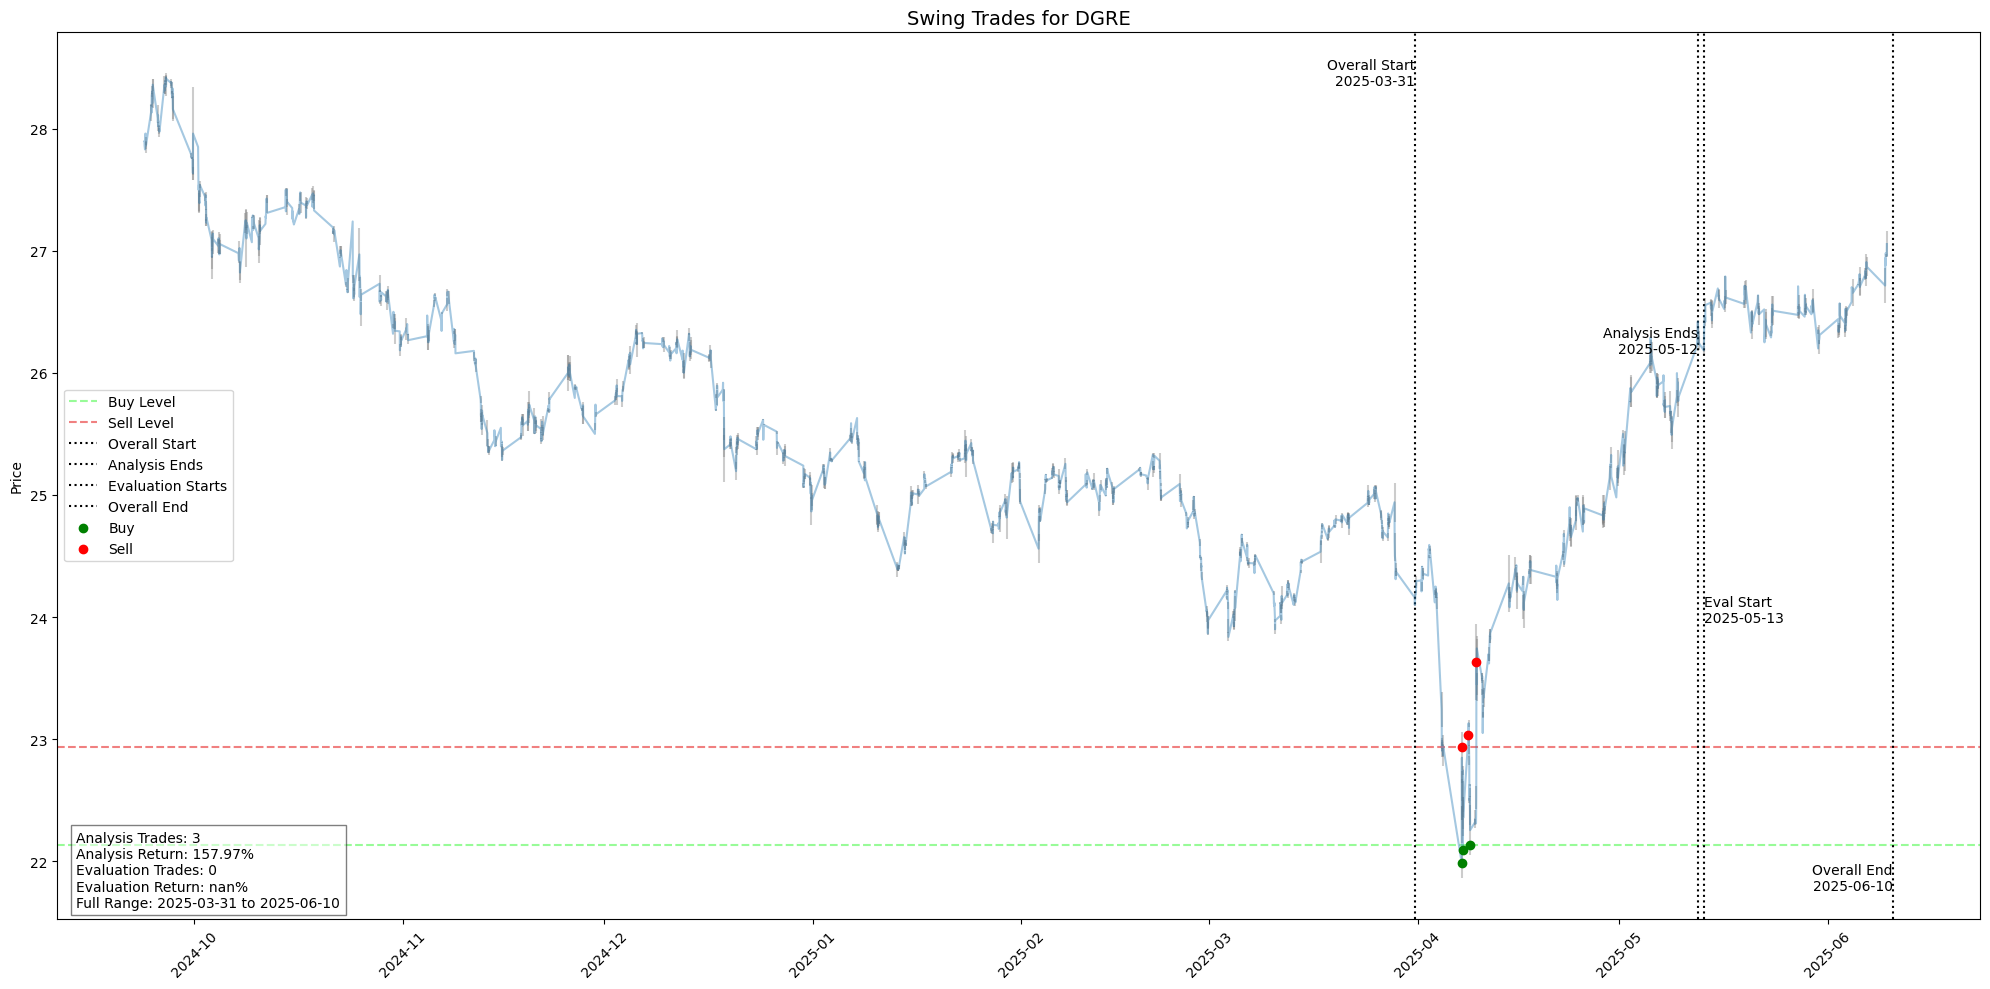

Plotting row 1 for DGRE...


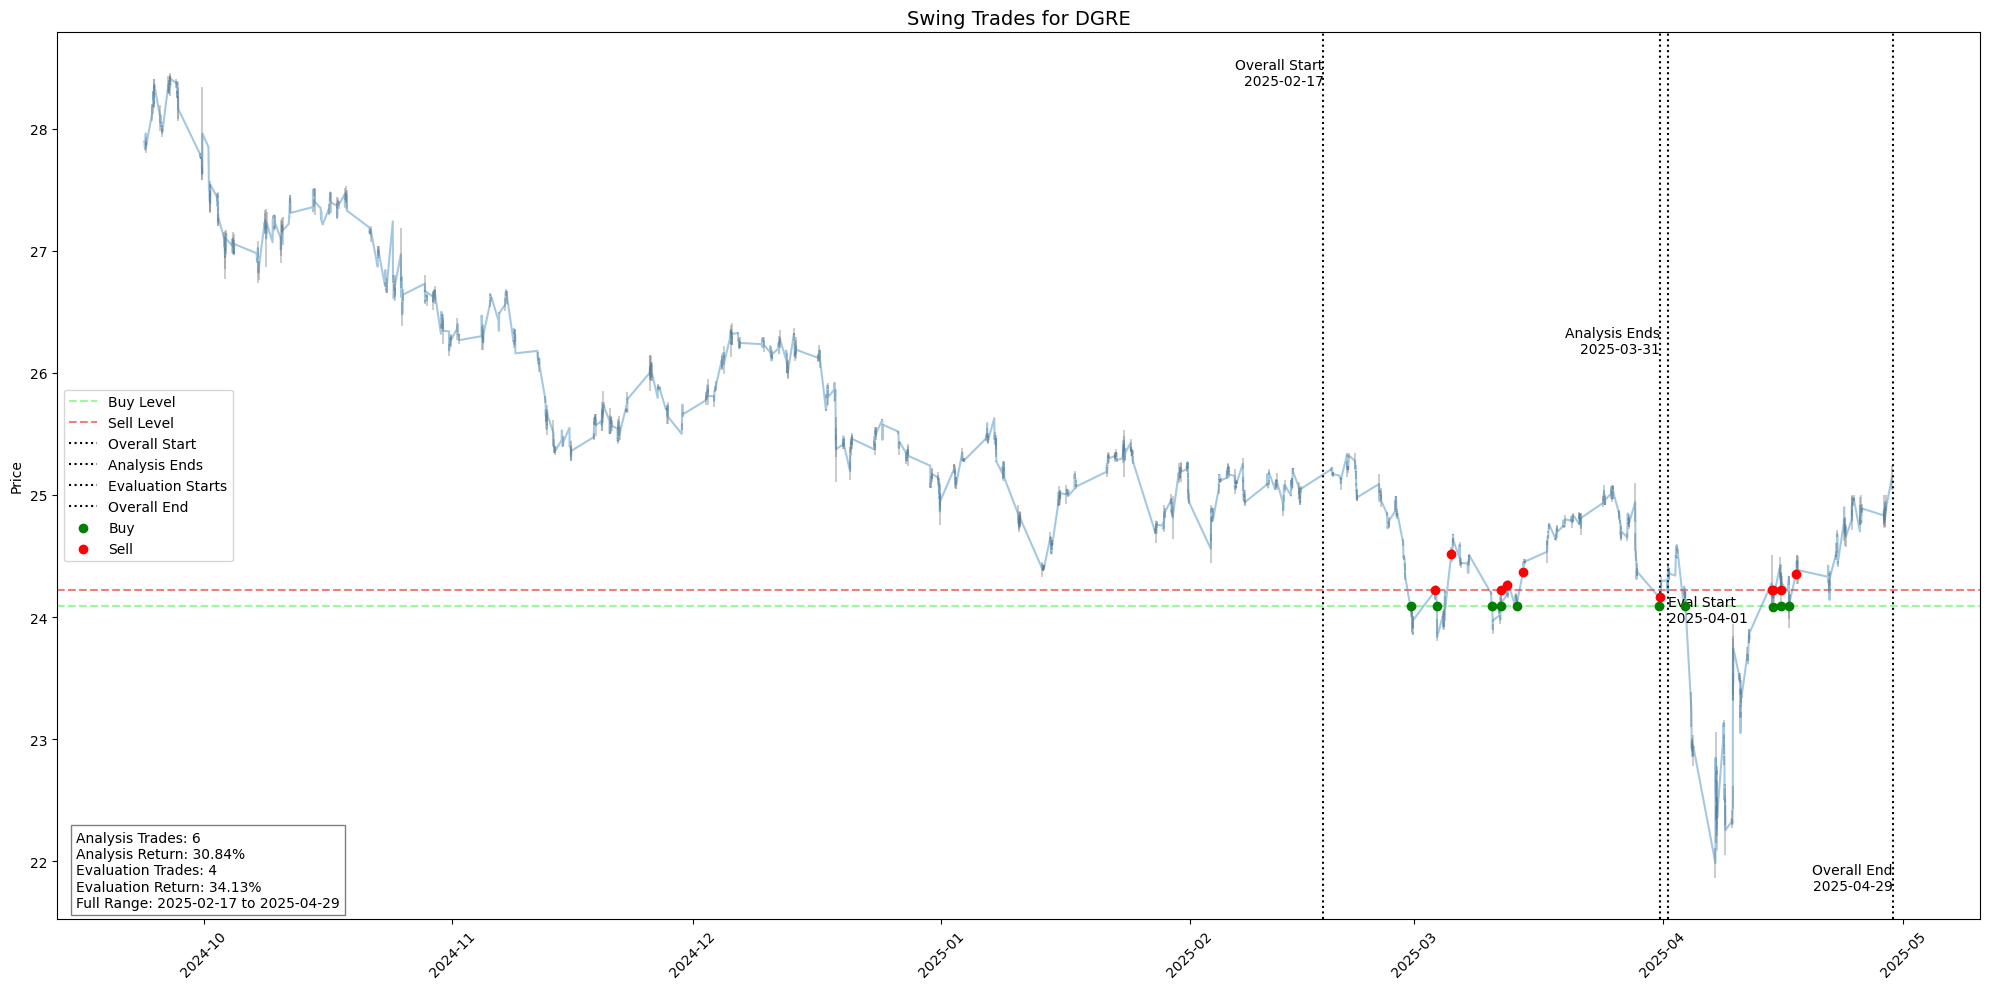

Plotting row 2 for DGRE...


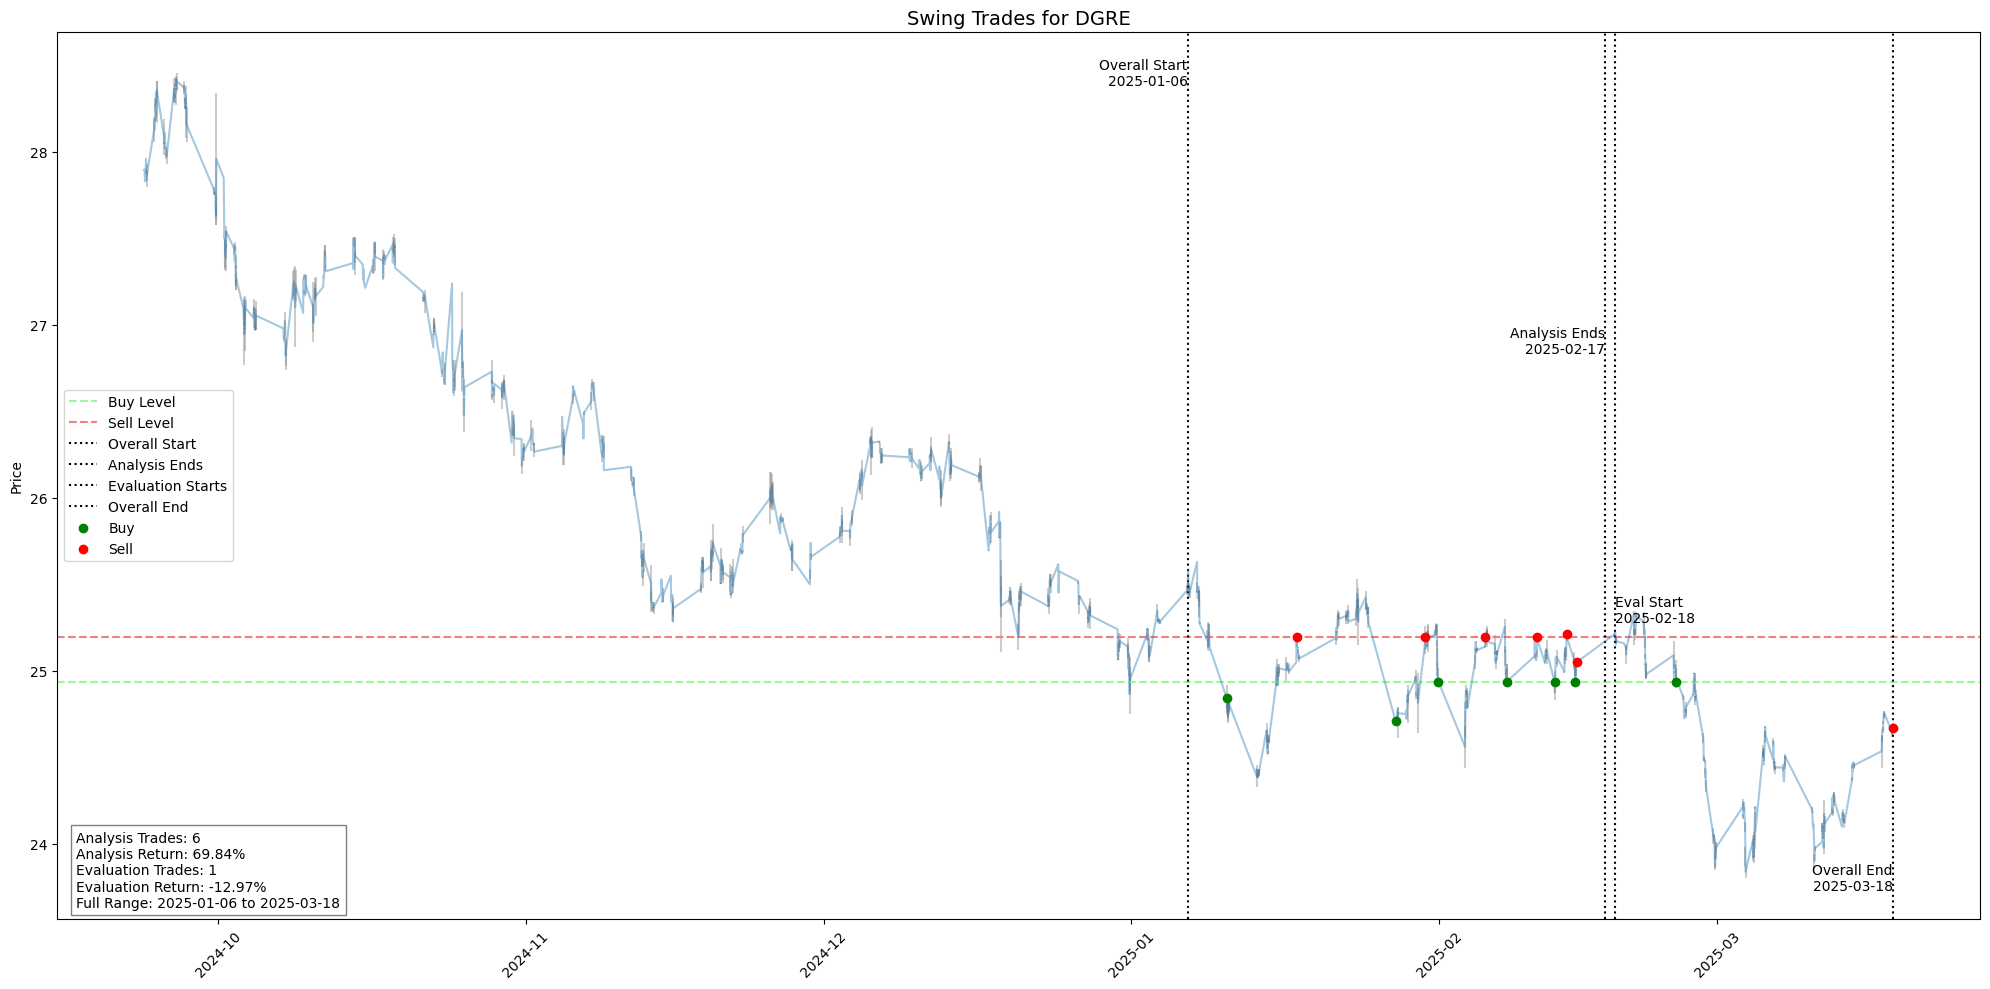

Plotting row 0 for BEAM...
⚠️ Missing 'type' column in trades_eval — likely no trades occurred.


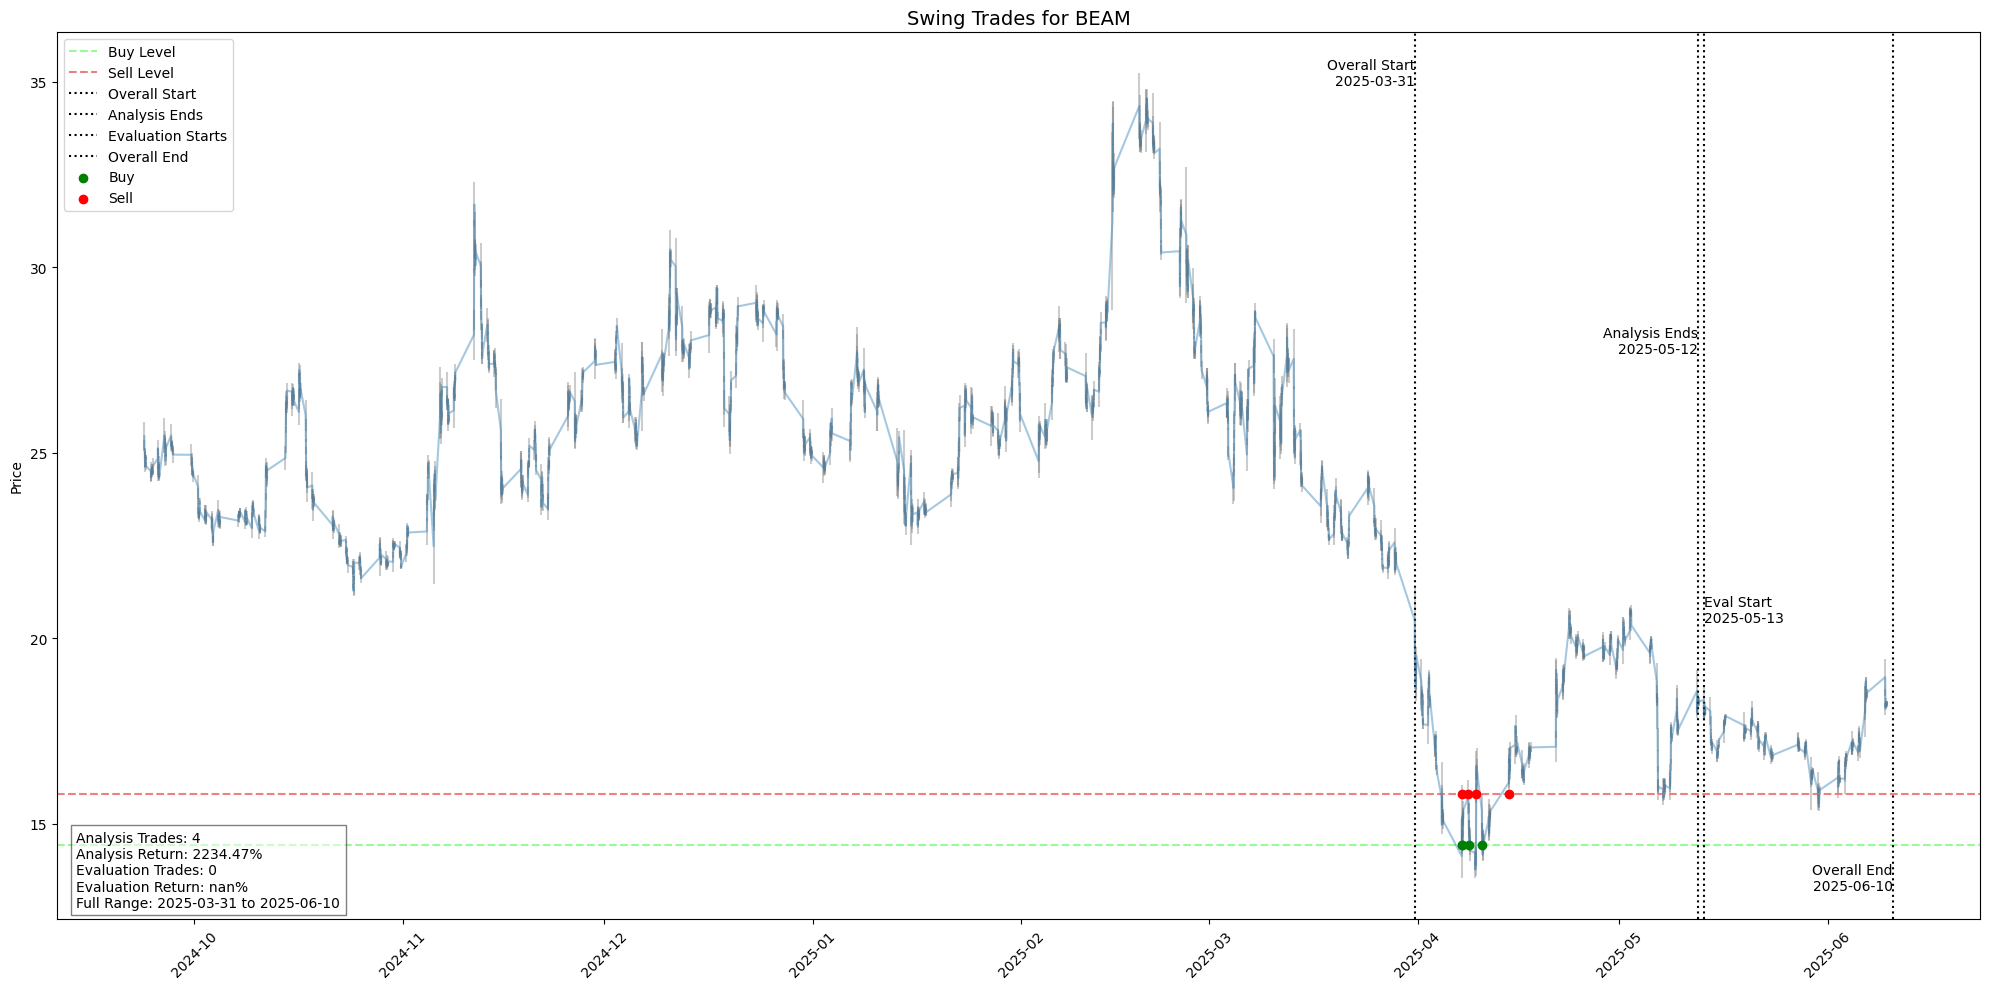

Plotting row 1 for BEAM...


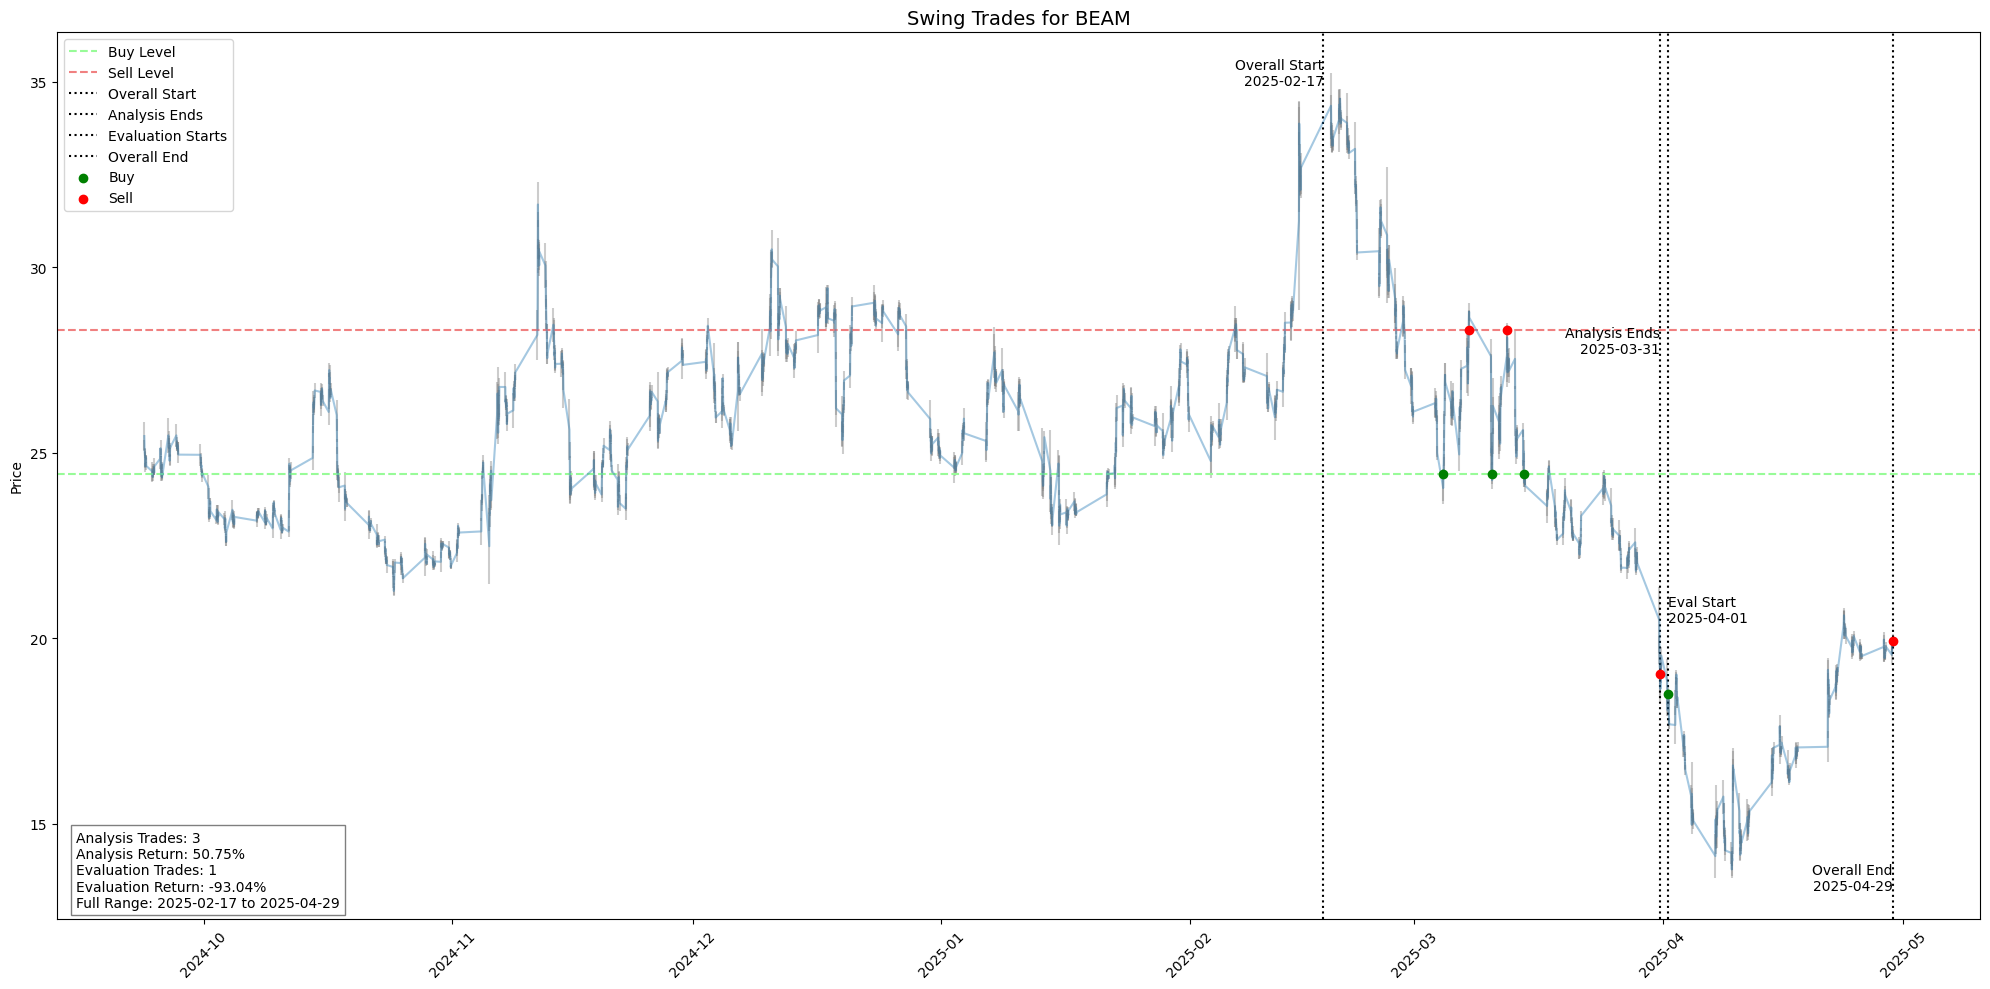

Plotting row 2 for BEAM...


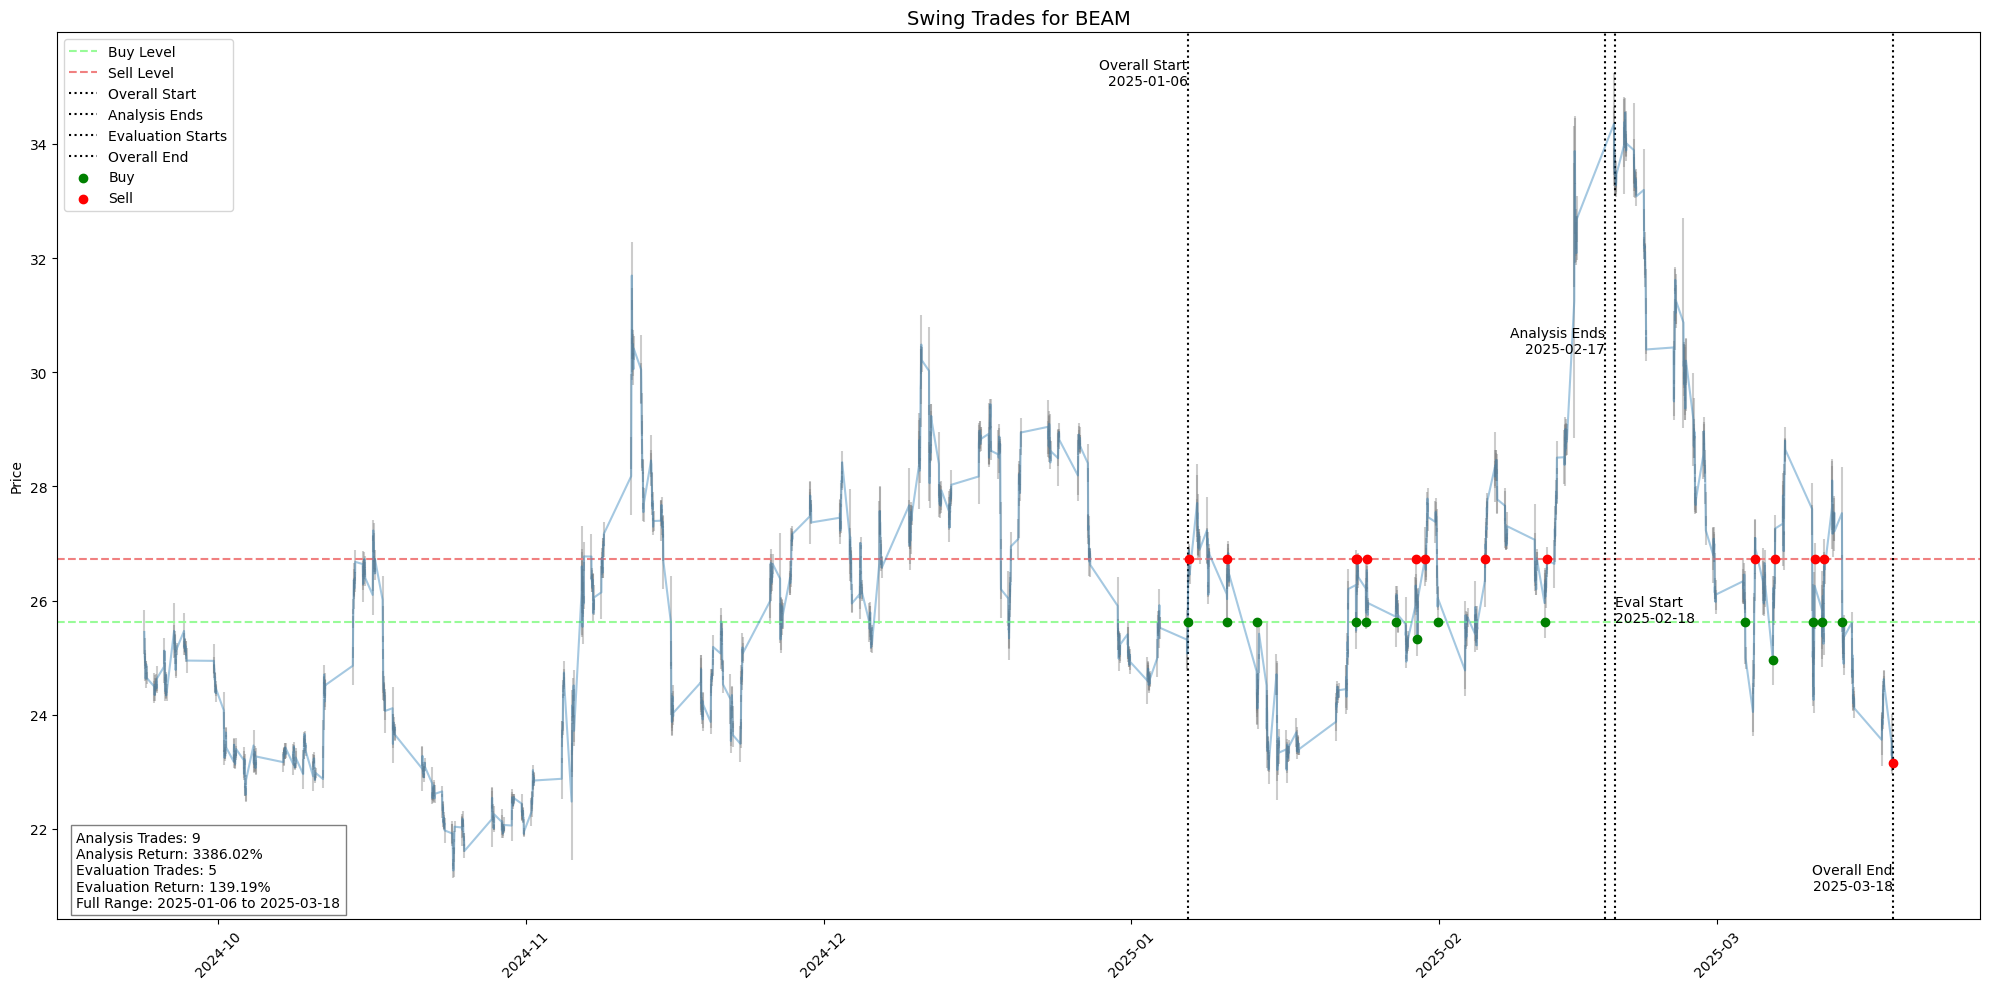

In [51]:
plot_random_ticker_trades(final_results_dict_schwab, local_folder="local-ticker-data-schwab")

Plot random tickers' analyses from GBQ base.

Plotting row 0 for CW...
⚠️ Missing 'type' column in trades_eval — likely no trades occurred.


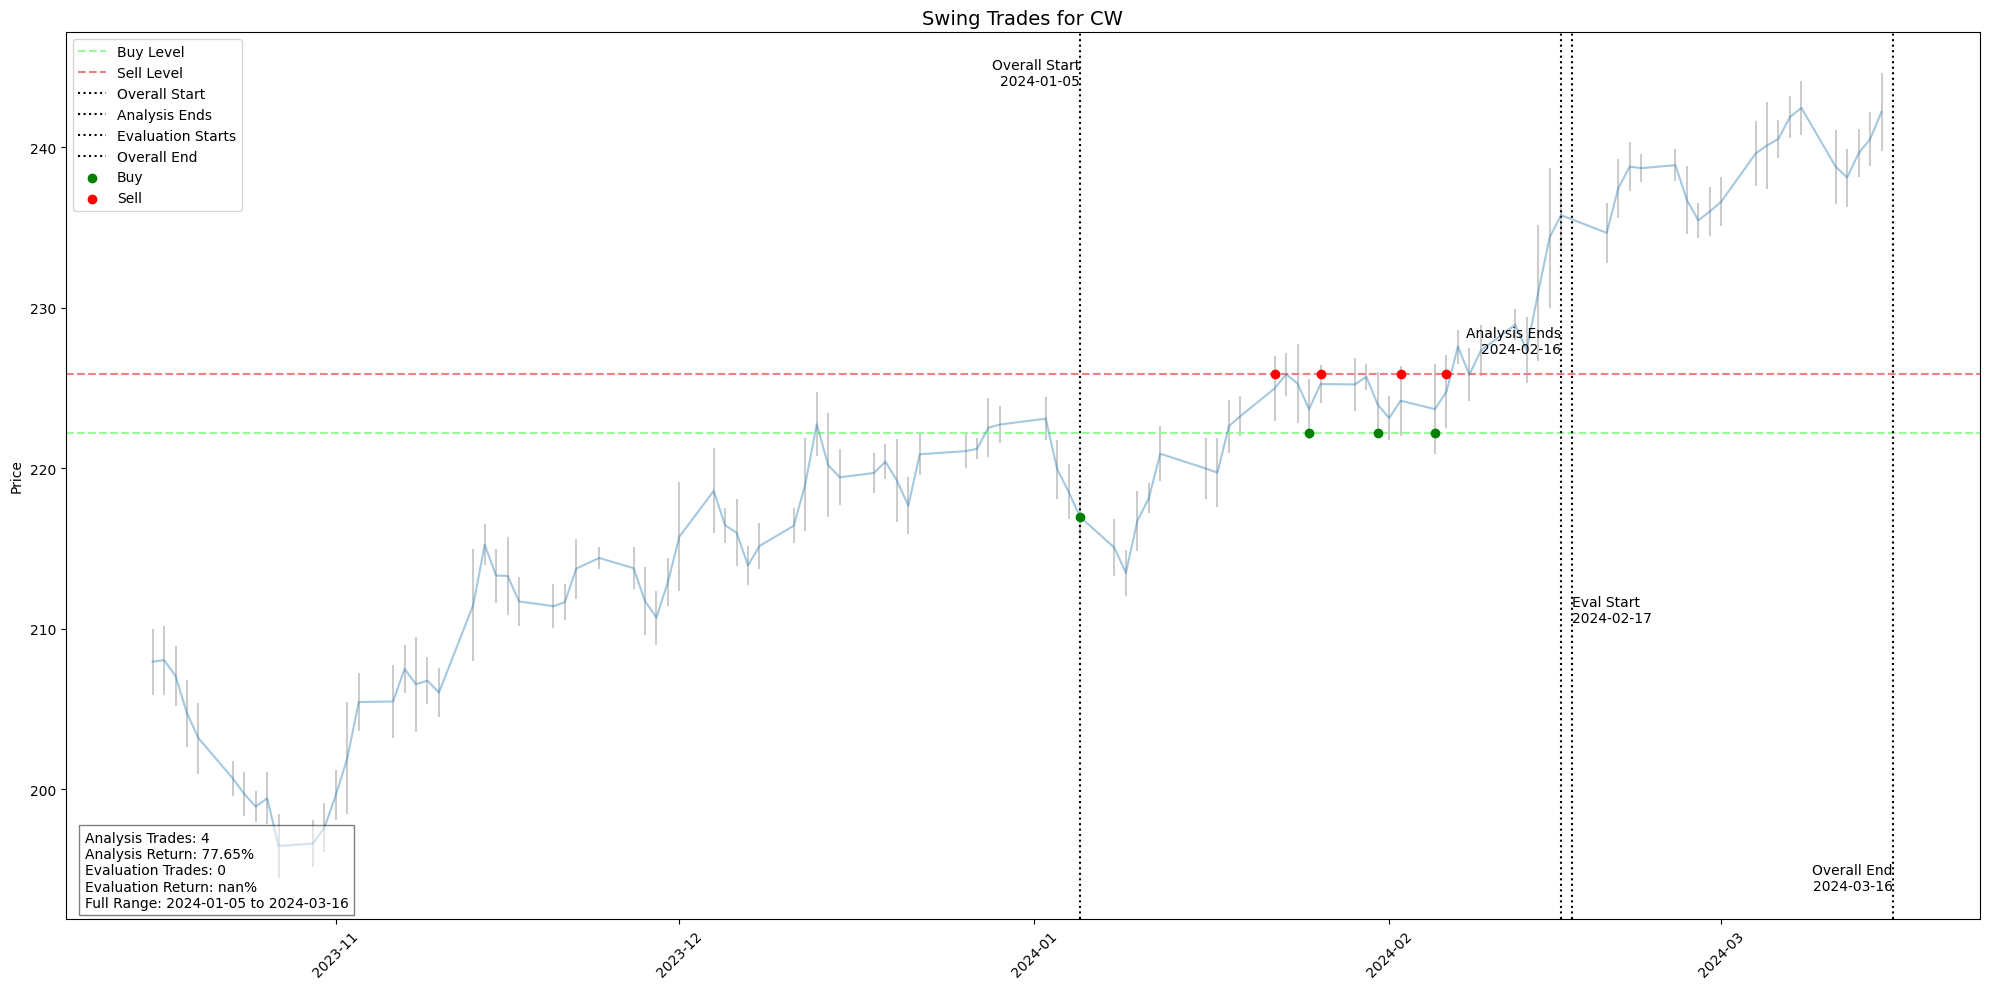

Plotting row 1 for CW...


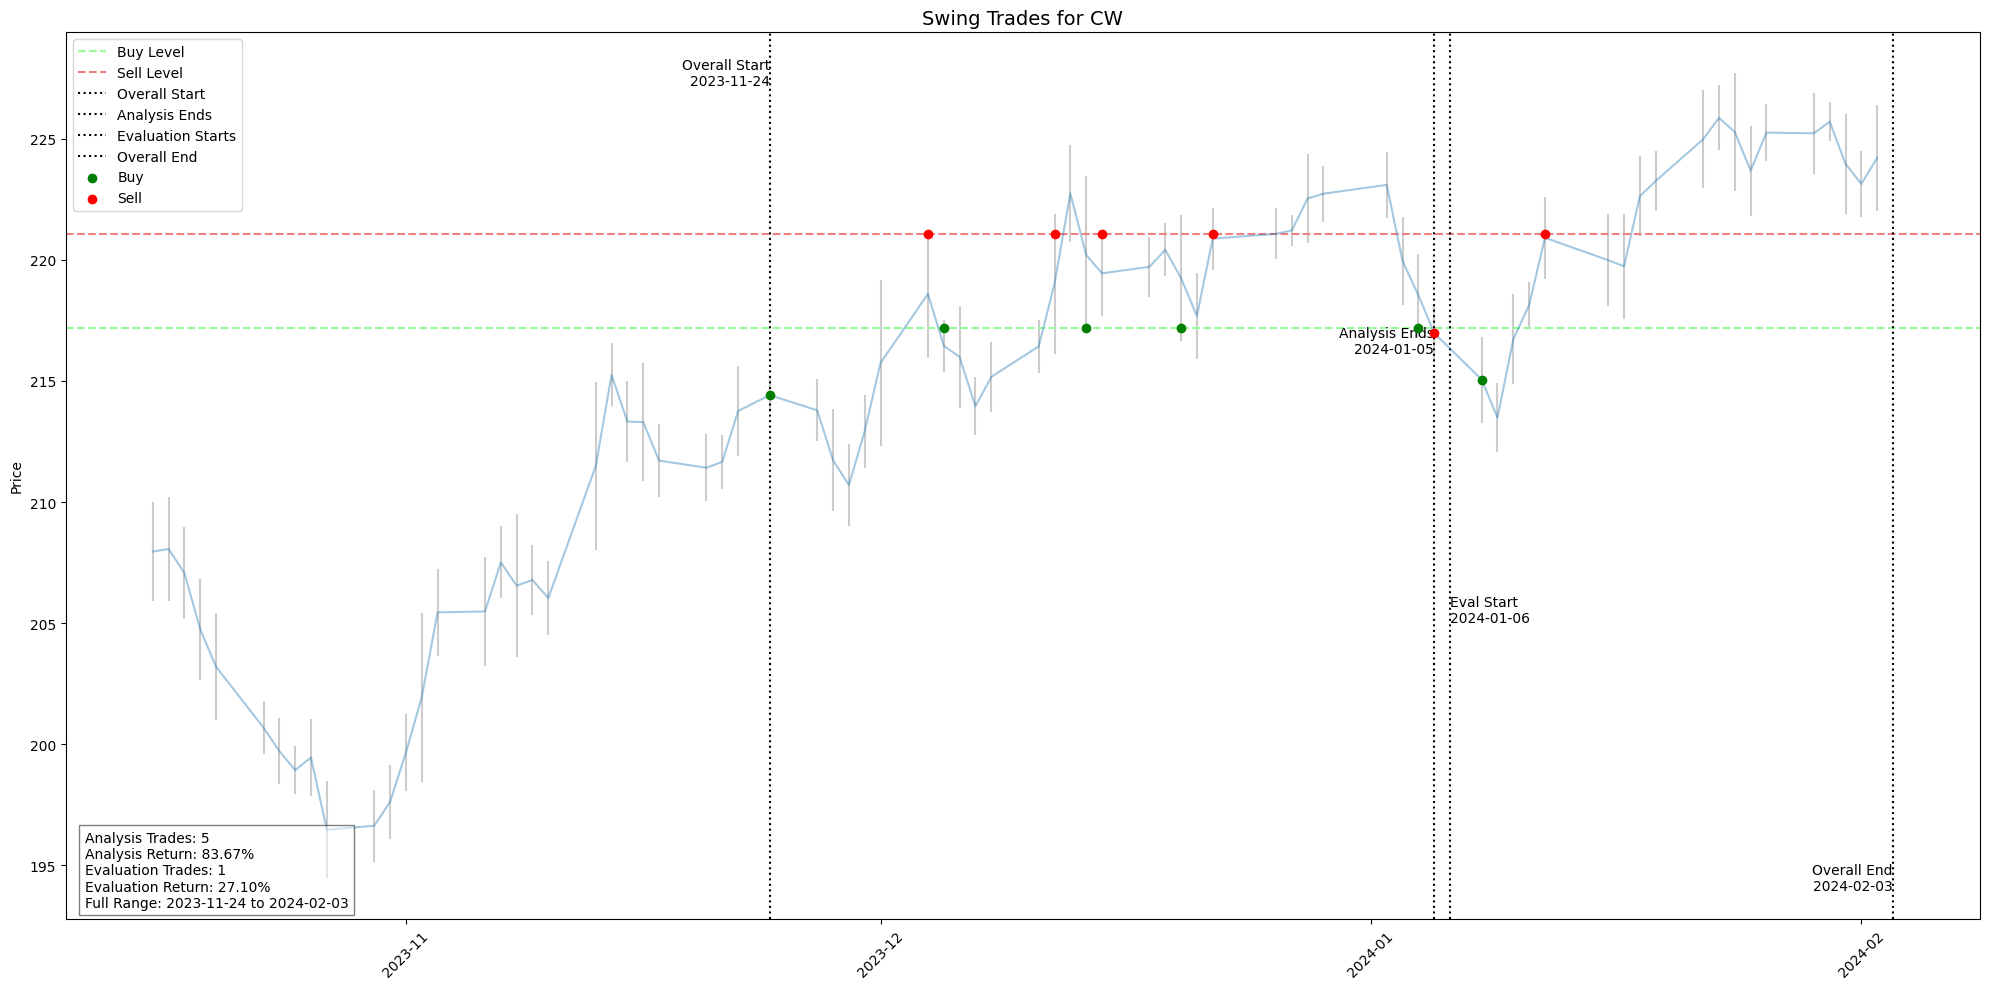

Plotting row 2 for CW...
⚠️ Missing 'type' column in trades_eval — likely no trades occurred.


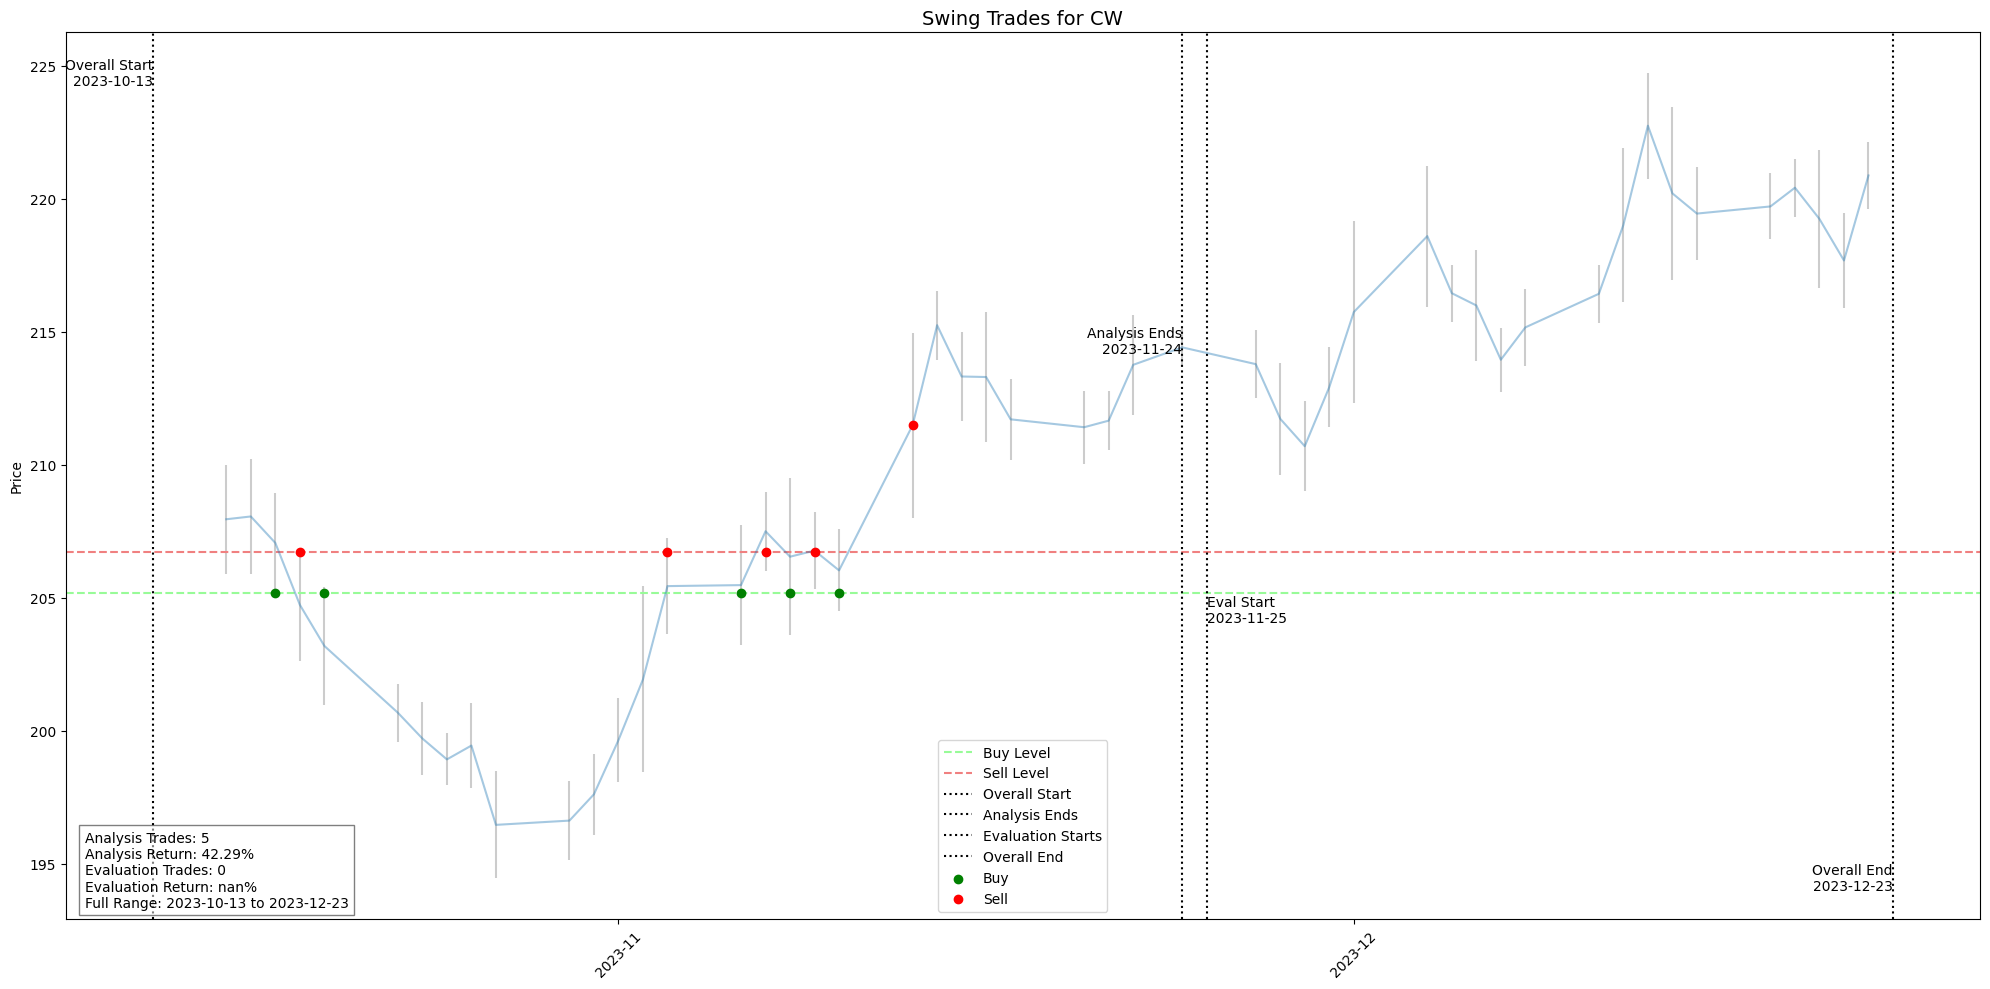

Plotting row 0 for TFSL...


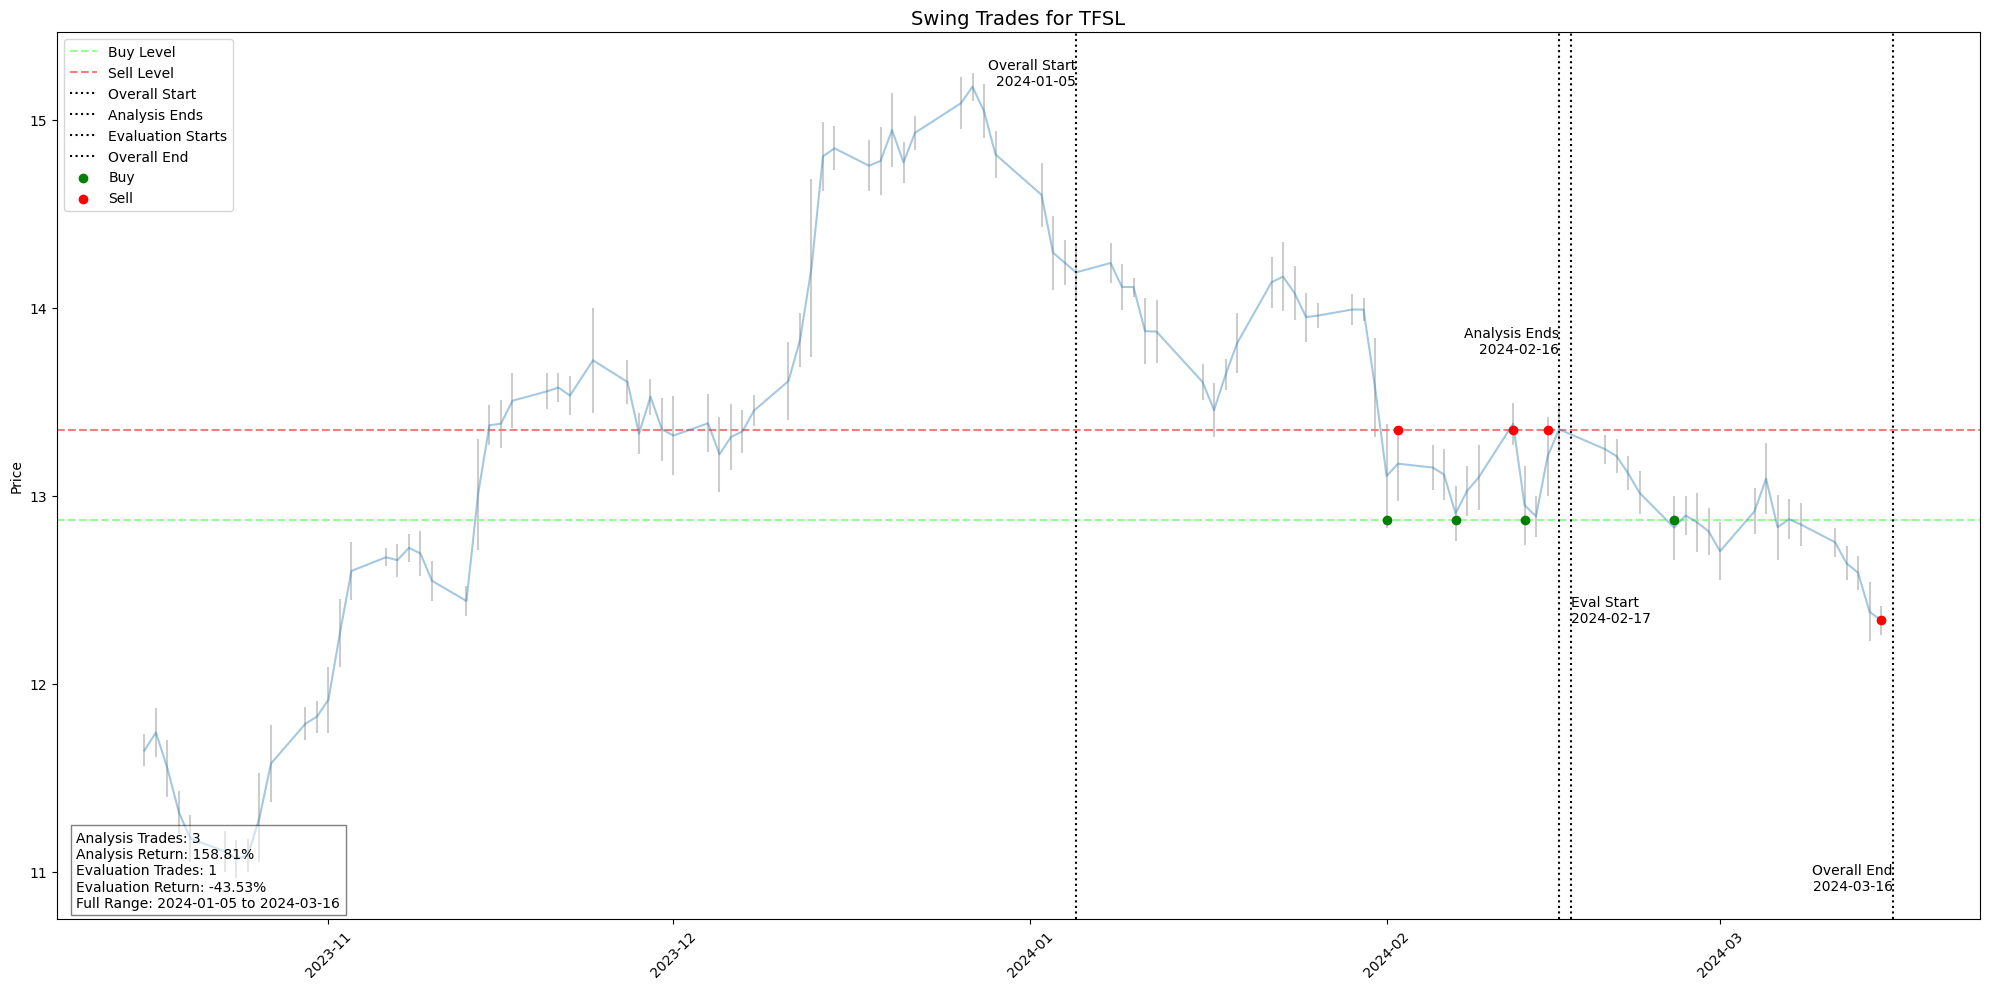

Plotting row 1 for TFSL...


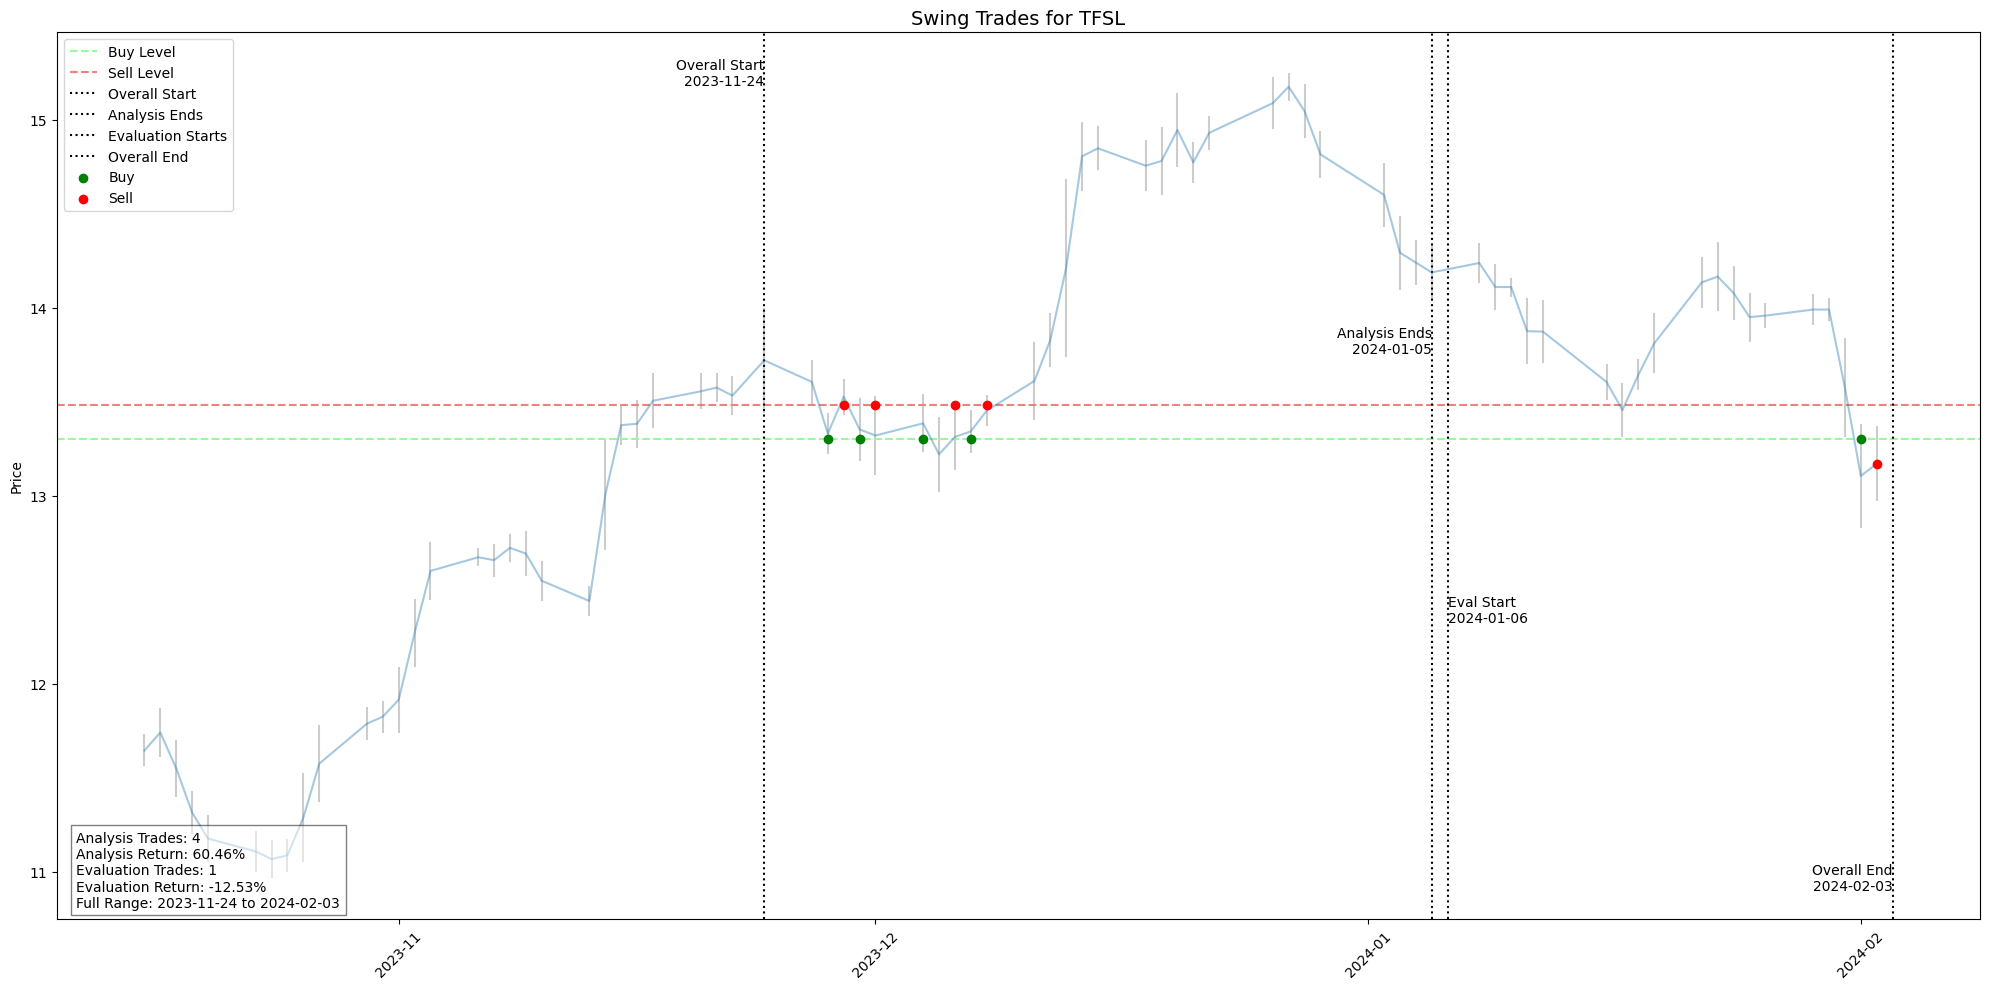

Plotting row 2 for TFSL...
⚠️ Missing 'type' column in trades_eval — likely no trades occurred.


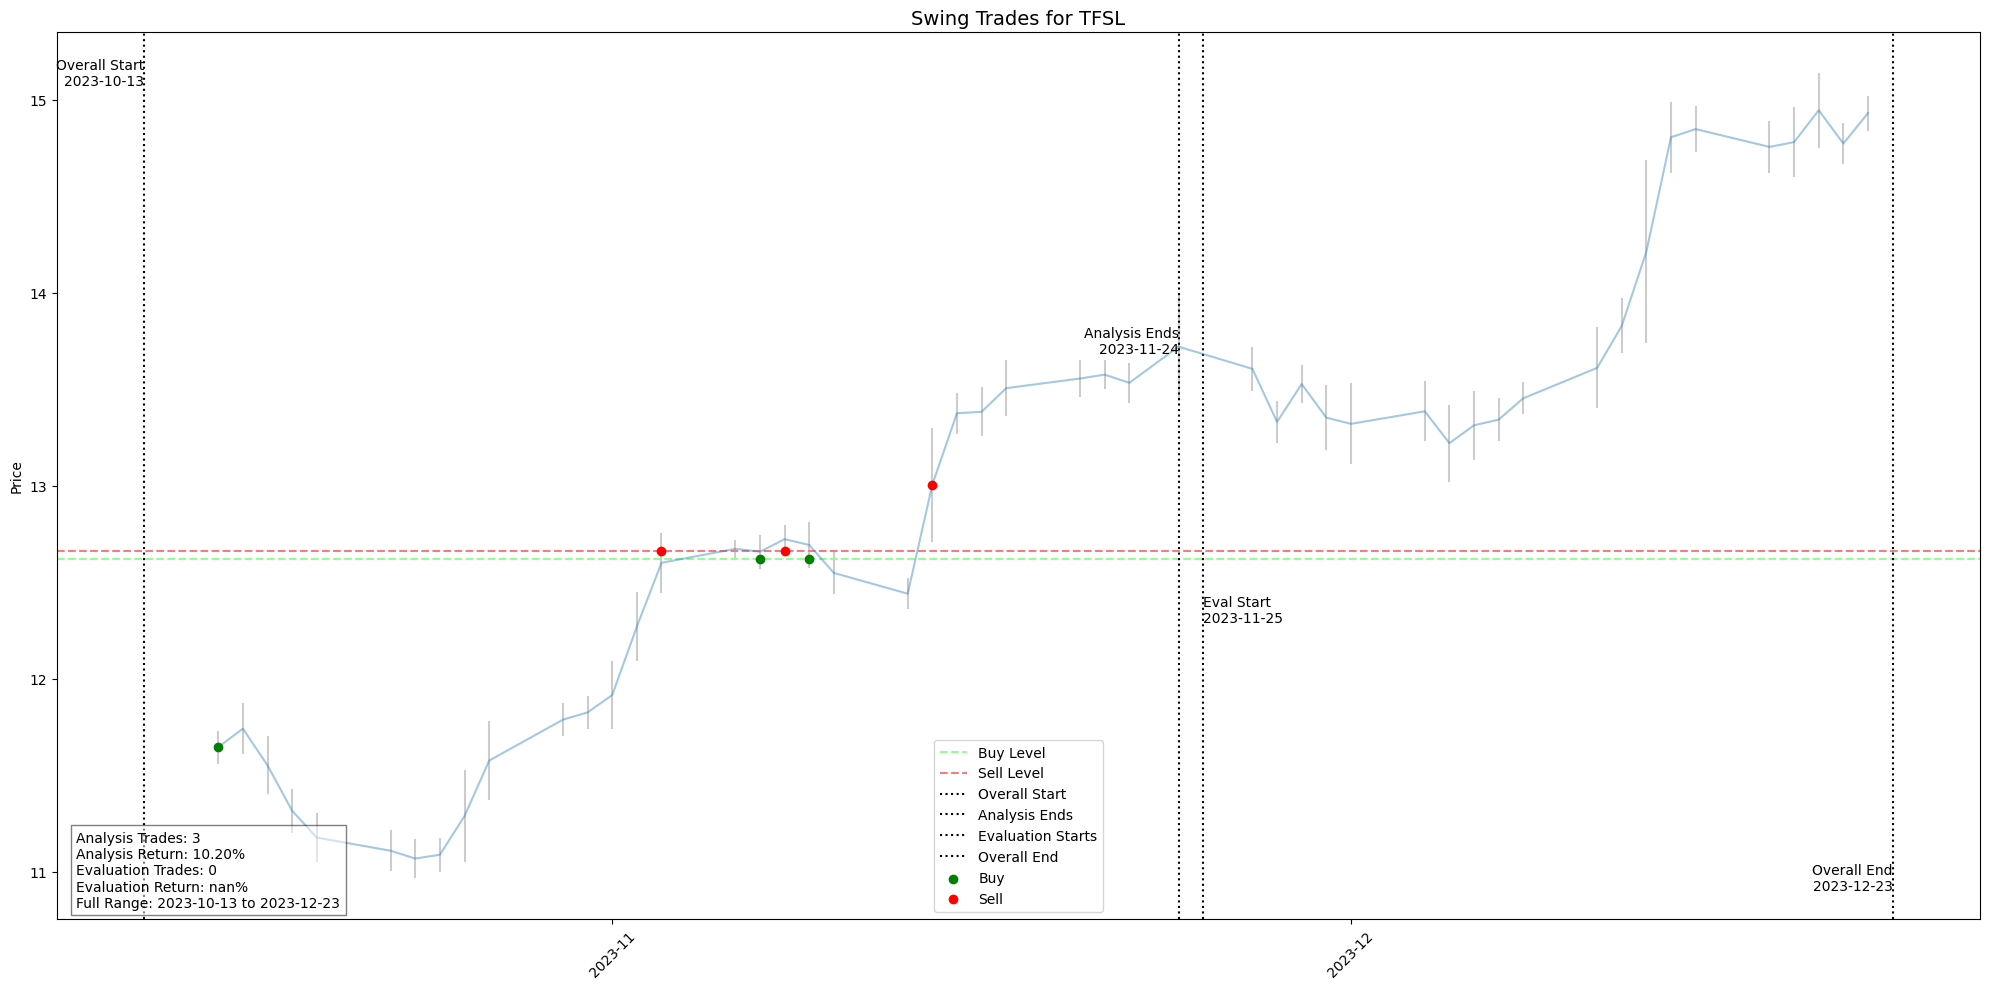

In [52]:
plot_random_ticker_trades(final_results_dict_gbq, local_folder="local-ticker-data-gbq")

### Up next... Figure out what this is and integrate it into analysis

In [ ]:
def analyze_ticker(
    ticker,
    month_offset=9,
    date_pull_begin=None,
    length_out=15,
    verbose_output=True,
    save_experiment=False,
    date_slug=None
):
    """
    Run a swing trading parameter optimization on a single ticker.

    This function searches for the optimal lower-bound (buy threshold) and upper-bound
    (sell threshold) levels that maximize annualized return over a historical window.
    It builds a grid of lb/ub combinations, evaluates each using simulated trades,
    and returns the best result(s). Optionally, results can be plotted and saved.

    Args:
        ticker (str): The ticker symbol to analyze.
        month_offset (int): Number of months before the most recent date to define the analysis window.
        date_pull_begin (str or datetime, optional): Override to define the start date for data pulling.
        length_out (int): Number of grid points (per axis) to test in the lb/ub threshold search.
        verbose_output (bool): Whether to print trade tables and show a plot of best results.
        save_experiment (bool): If True, saves the full grid of results to disk as a tab-delimited file.
        date_slug (str, optional): Prefix for the experiment file name if saving.

    Returns:
        pd.DataFrame: A single-row or small subset DataFrame containing the best performing
                      threshold combination(s), with fields:
            - lb (float): lower bound (buy threshold)
            - ub (float): upper bound (sell threshold)
            - return (float): annualized return
            - trades (int): number of trades triggered
            - time_start (datetime): start date of the analysis window

    Raises:
        ValueError: If neither `month_offset` nor `date_pull_begin` is supplied.
    """
    if not month_offset and not date_pull_begin:
        raise ValueError("You must provide either month_offset or date_pull_begin")

    if date_pull_begin is None:
        date_pull_begin = pd.Timestamp.today() - pd.DateOffset(months=int(1.25 * month_offset))
    else:
        date_pull_begin = pd.to_datetime(date_pull_begin)

    # Pull data
    data = get_ticker_data(ticker, date_pull_begin)

    lb_start = data["low"].quantile(0.01)
    lb_end = data["low"].quantile(0.75)
    ub_start = data["high"].quantile(0.10)
    ub_end = data["high"].quantile(0.99)

    last_date = data["date_time"].max()
    time_start = last_date - pd.DateOffset(months=month_offset)

    # Build grid
    lb_vals = np.linspace(lb_start, lb_end, length_out)
    ub_vals = np.linspace(ub_start, ub_end, length_out)
    grid = []

    for lb in lb_vals:
        for ub in ub_vals:
            if lb >= ub:
                continue
            result = get_returns(data, upper_bound=ub, lower_bound=lb, time_start=time_start)
            grid.append({
                "lb": lb,
                "ub": ub,
                "time_start": time_start,
                "return": result["annualized_return"],
                "trades": result["num_trades"]
            })

    grid_df = pd.DataFrame(grid).dropna(subset=["return"])

    if save_experiment:
        if not date_slug:
            date_slug = pd.Timestamp.today().strftime("%Y%m%d")
        output_file = Path("swing-trading/experiments") / f"{date_slug}_{ticker}_swing_experiments.txt"
        grid_df.to_csv(output_file, sep="\t", index=False)

    if grid_df.empty:
        print("No valid trade setups found.")
        return grid_df

    max_trades = grid_df["trades"].max()
    returns_80pct = grid_df["return"].quantile(0.80)

    if max_trades <= 6:
        top = grid_df.sort_values(["trades", "return"], ascending=[True, True]).tail(5 if verbose_output else 1)
    else:
        top = grid_df[(grid_df["return"] > returns_80pct)].sort_values("trades").tail(5 if verbose_output else 1)

    if verbose_output and not top.empty:
        best = top.iloc[-1]
        best_trades = get_trades(data, best["ub"], best["lb"], best["time_start"])
        print(best_trades[["date", "type", "trade_price"]].to_string(index=False))
        print("---------------------------")

        # Plot
        plot_data = data[data["date_time"] >= best["time_start"]]
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.errorbar(
            plot_data["date_time"],
            y=(plot_data["high"] + plot_data["low"]) / 2,
            yerr=(plot_data["high"] - plot_data["low"]) / 2,
            fmt='-', ecolor='gray', alpha=0.5
        )
        ax.axhline(best["lb"], color="lightblue", linestyle="--")
        ax.axhline(best["ub"], color="lightblue", linestyle="--")
        ax.set_title(f"Swings for {ticker}")
        ax.set_ylabel("Price")
        ax.set_xlabel("")
        ax.text(0.01, 0.01, f"Maximum return: {best['return']:.1%}", transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.5))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return top.reset_index(drop=True)